In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
#     return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.fe_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )

        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.fe_last = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
        )
        
    def forward(self, source_data):
        
        ### step 1
        h_data = self.fe_layer(source_data)
        h_data = h_data.reshape((len(source_data), self.chunk_size, -1))
        
        ### step 2
        h_data = self.pos_encoder(h_data)
        z = self.encoder(h_data)
        
        ### step 3
        pred_data = z.reshape((len(source_data), self.chunk_size, self.seq_len, -1))
        pred_data = self.fe_last(pred_data)
        
        return pred_data
        

In [19]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [20]:
def generator_loss(pred_data, target_data):
    lin_acc_loss = mse_loss(pred_data[:, :, :, 0:3], target_data[:, :, :, 0:3])
    gro_loss = mse_loss(pred_data[:, :, :, 3:6], target_data[:, :, :, 3:6])
    mag_loss = mse_loss(pred_data[:, :, :, 6:9], target_data[:, :, :, 6:9])

    total_loss = lin_acc_loss + gro_loss + mag_loss
    return total_loss, lin_acc_loss, gro_loss, mag_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [21]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = pocket_pair_data[:pocket_half]  # swing_pair_data[:swing_half] + front_pocket_pair_data[:front_pocket_half] + 
valid_data = pocket_pair_data[pocket_half:]  # swing_pair_data[swing_half:] + front_pocket_pair_data[front_pocket_half:] + 

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [22]:
batch = next(iter(train_loader))

In [23]:
# batch

In [24]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()

In [25]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [26]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [27]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data[:, :, :, 0:9].to(device)
        target_data = target_data[:, :, :, 0:9].to(device)

        # generate mag
        predict_data = model(source_data)
        
        # generator loss
        gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        lin_acc_losses.append(lin_acc_loss.item())
        gro_losses.append(gro_loss.item())
        mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

In [28]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            # record loss
            g_losses.append(gen_loss.item())
            lin_acc_losses.append(lin_acc_loss.item())
            gro_losses.append(gro_loss.item())
            mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

00020: train loss:  639.459, lin acc loss:  1.465, gro loss:  0.599, mag loss:  637.395
       valid loss:  597.617, lin acc loss:  1.408, gro loss:  0.588, mag loss:  595.622
00040: train loss:  646.853, lin acc loss:  1.474, gro loss:  0.656, mag loss:  644.723
       valid loss:  592.478, lin acc loss:  1.456, gro loss:  0.640, mag loss:  590.382
00060: train loss:  626.819, lin acc loss:  1.454, gro loss:  0.621, mag loss:  624.745
       valid loss:  588.064, lin acc loss:  1.416, gro loss:  0.615, mag loss:  586.033
00080: train loss:  604.201, lin acc loss:  1.549, gro loss:  0.647, mag loss:  602.005
       valid loss:  579.348, lin acc loss:  1.406, gro loss:  0.631, mag loss:  577.312
00100: train loss:  638.675, lin acc loss:  1.442, gro loss:  0.620, mag loss:  636.614
       valid loss:  575.859, lin acc loss:  1.380, gro loss:  0.585, mag loss:  573.893
00120: train loss:  595.286, lin acc loss:  1.441, gro loss:  0.613, mag loss:  593.232
       valid loss:  567.063, lin

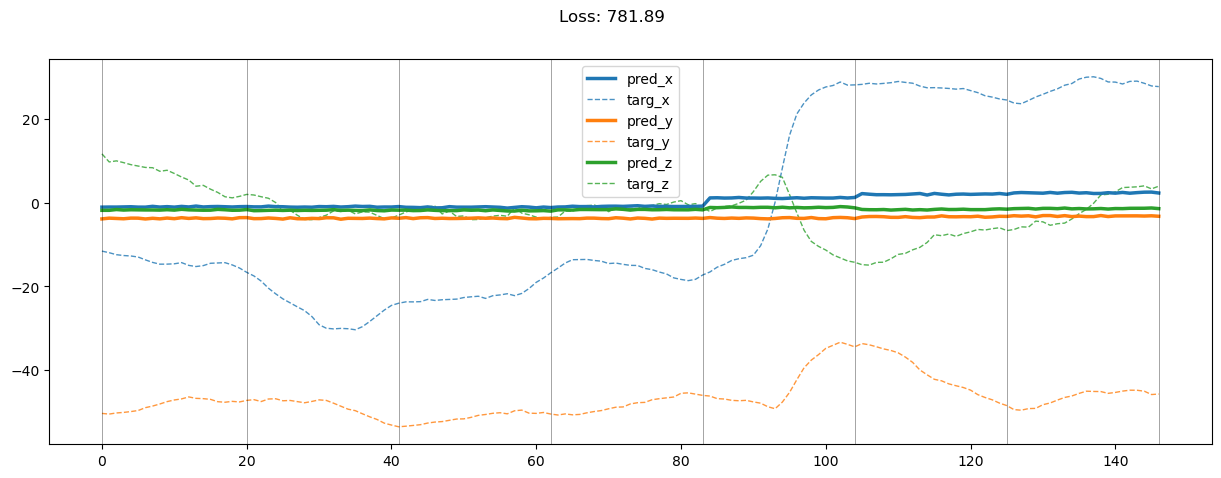

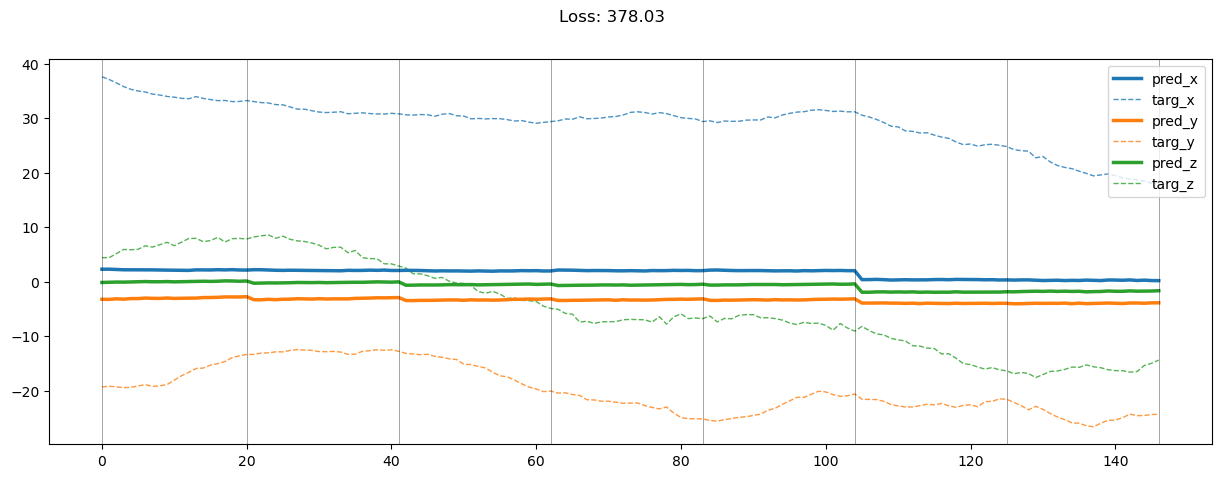

00200: train loss:  569.484, lin acc loss:  1.342, gro loss:  0.537, mag loss:  567.605
       valid loss:  543.523, lin acc loss:  1.284, gro loss:  0.534, mag loss:  541.705
00220: train loss:  570.894, lin acc loss:  1.409, gro loss:  0.552, mag loss:  568.933
       valid loss:  539.130, lin acc loss:  1.258, gro loss:  0.503, mag loss:  537.369
00240: train loss:  558.752, lin acc loss:  1.388, gro loss:  0.475, mag loss:  556.889
       valid loss:  531.171, lin acc loss:  1.262, gro loss:  0.431, mag loss:  529.478
00260: train loss:  547.054, lin acc loss:  1.361, gro loss:  0.449, mag loss:  545.244
       valid loss:  524.553, lin acc loss:  1.249, gro loss:  0.400, mag loss:  522.904
00280: train loss:  555.379, lin acc loss:  1.354, gro loss:  0.375, mag loss:  553.650
       valid loss:  515.939, lin acc loss:  1.223, gro loss:  0.352, mag loss:  514.363
00300: train loss:  537.495, lin acc loss:  1.327, gro loss:  0.356, mag loss:  535.812
       valid loss:  509.317, lin

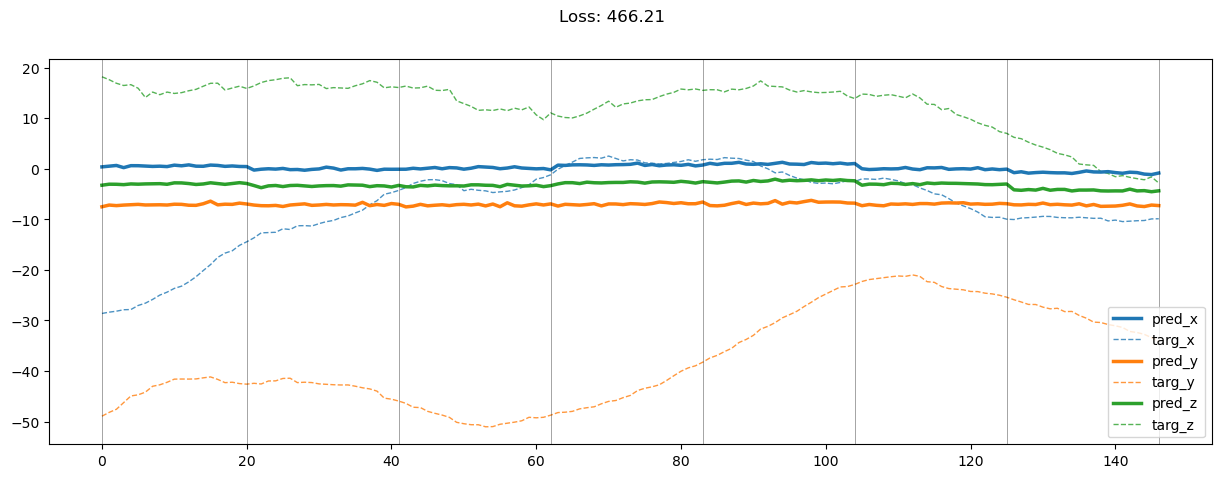

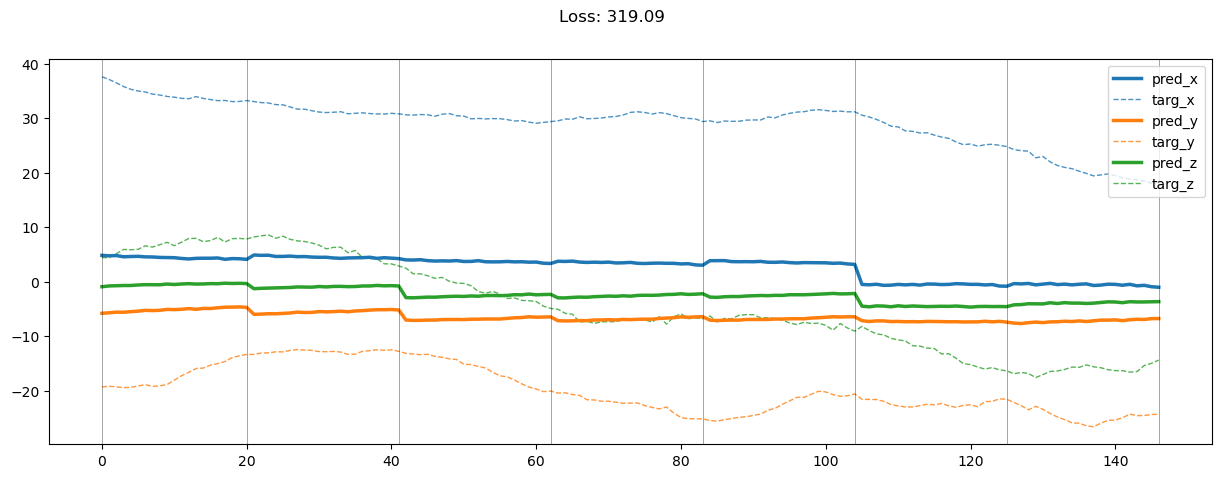

00400: train loss:  471.713, lin acc loss:  1.302, gro loss:  0.255, mag loss:  470.156
       valid loss:  476.237, lin acc loss:  1.188, gro loss:  0.240, mag loss:  474.809
00420: train loss:  471.470, lin acc loss:  1.404, gro loss:  0.261, mag loss:  469.805
       valid loss:  469.903, lin acc loss:  1.185, gro loss:  0.231, mag loss:  468.487
00440: train loss:  467.311, lin acc loss:  1.326, gro loss:  0.261, mag loss:  465.724
       valid loss:  457.909, lin acc loss:  1.181, gro loss:  0.220, mag loss:  456.509
00460: train loss:  458.857, lin acc loss:  1.282, gro loss:  0.245, mag loss:  457.330
       valid loss:  457.255, lin acc loss:  1.180, gro loss:  0.213, mag loss:  455.862
00480: train loss:  463.751, lin acc loss:  1.389, gro loss:  0.260, mag loss:  462.102
       valid loss:  446.858, lin acc loss:  1.175, gro loss:  0.214, mag loss:  445.469
00500: train loss:  429.379, lin acc loss:  1.168, gro loss:  0.236, mag loss:  427.976
       valid loss:  436.731, lin

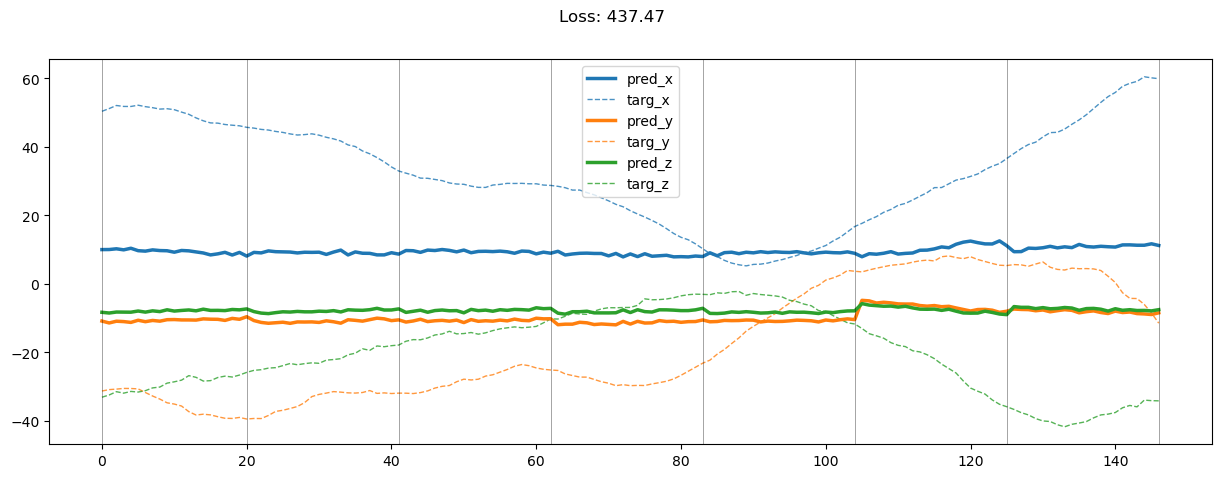

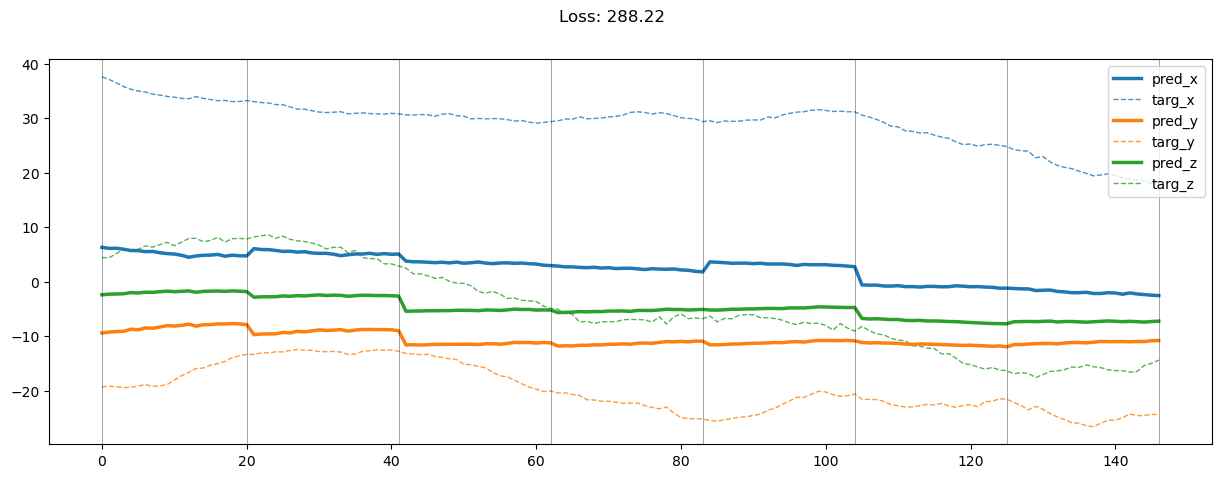

00600: train loss:  367.895, lin acc loss:  1.334, gro loss:  0.244, mag loss:  366.317
       valid loss:  403.446, lin acc loss:  1.165, gro loss:  0.202, mag loss:  402.079
00620: train loss:  366.876, lin acc loss:  1.371, gro loss:  0.250, mag loss:  365.255
       valid loss:  399.262, lin acc loss:  1.163, gro loss:  0.201, mag loss:  397.898
00640: train loss:  352.808, lin acc loss:  1.337, gro loss:  0.238, mag loss:  351.232
       valid loss:  392.640, lin acc loss:  1.159, gro loss:  0.192, mag loss:  391.289
00660: train loss:  351.387, lin acc loss:  1.256, gro loss:  0.220, mag loss:  349.910
       valid loss:  382.306, lin acc loss:  1.161, gro loss:  0.194, mag loss:  380.952
00680: train loss:  339.542, lin acc loss:  1.171, gro loss:  0.216, mag loss:  338.154
       valid loss:  381.473, lin acc loss:  1.165, gro loss:  0.191, mag loss:  380.117
00700: train loss:  323.387, lin acc loss:  1.253, gro loss:  0.213, mag loss:  321.922
       valid loss:  372.937, lin

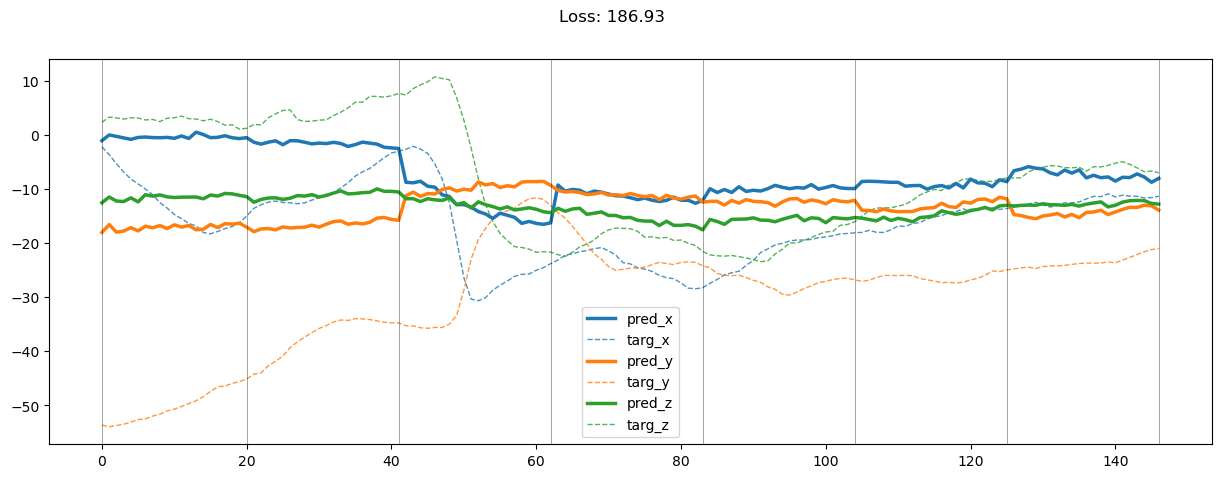

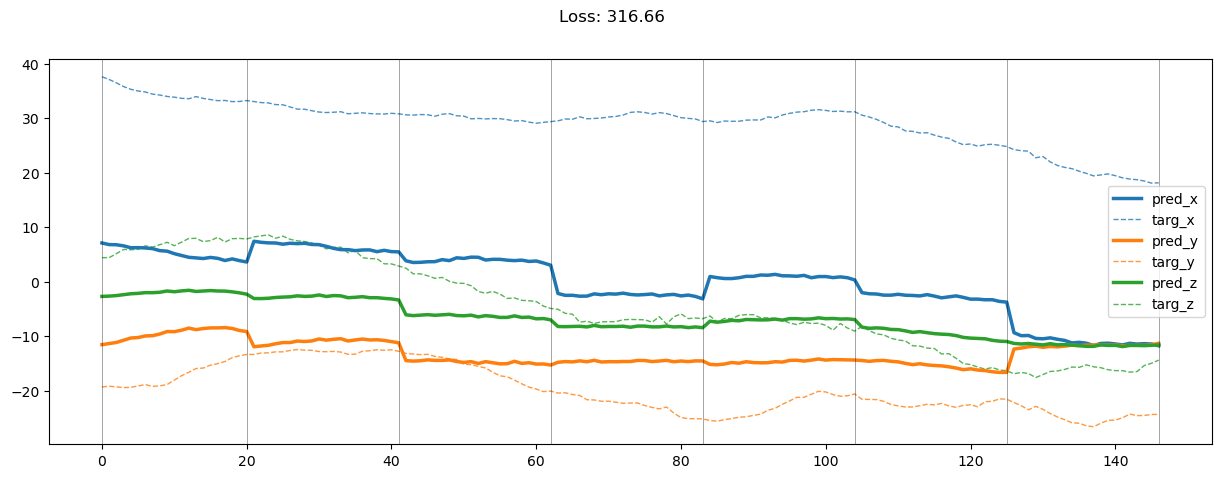

00800: train loss:  279.398, lin acc loss:  1.279, gro loss:  0.201, mag loss:  277.918
       valid loss:  342.411, lin acc loss:  1.160, gro loss:  0.177, mag loss:  341.074
00820: train loss:  268.801, lin acc loss:  1.381, gro loss:  0.222, mag loss:  267.198
       valid loss:  337.231, lin acc loss:  1.160, gro loss:  0.175, mag loss:  335.895
00840: train loss:  244.575, lin acc loss:  1.288, gro loss:  0.208, mag loss:  243.079
       valid loss:  333.864, lin acc loss:  1.159, gro loss:  0.174, mag loss:  332.531
00860: train loss:  260.971, lin acc loss:  1.327, gro loss:  0.227, mag loss:  259.417
       valid loss:  323.063, lin acc loss:  1.161, gro loss:  0.181, mag loss:  321.722
00880: train loss:  233.778, lin acc loss:  1.146, gro loss:  0.202, mag loss:  232.430
       valid loss:  322.704, lin acc loss:  1.158, gro loss:  0.171, mag loss:  321.375
00900: train loss:  226.759, lin acc loss:  1.194, gro loss:  0.193, mag loss:  225.372
       valid loss:  317.663, lin

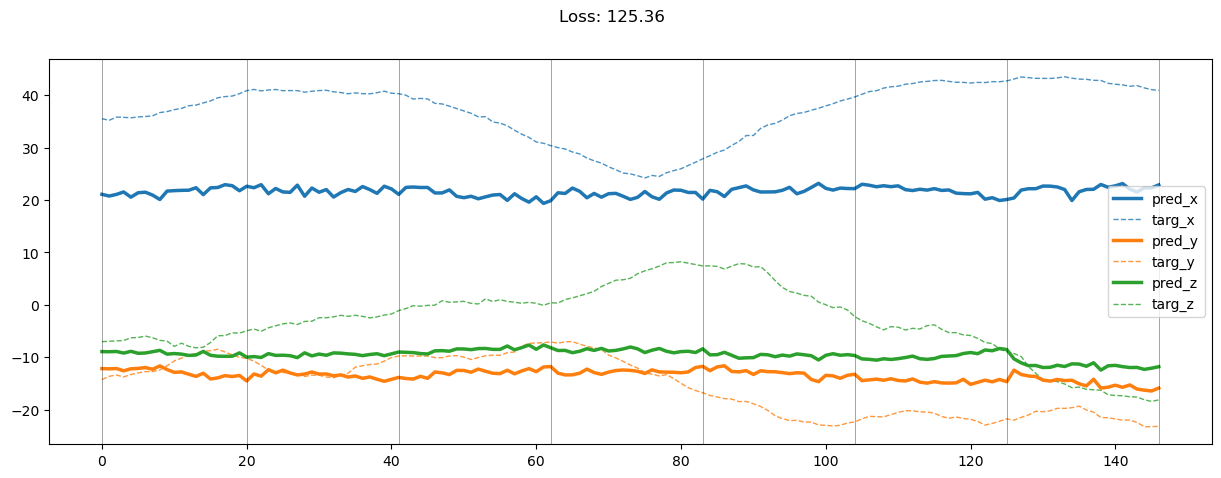

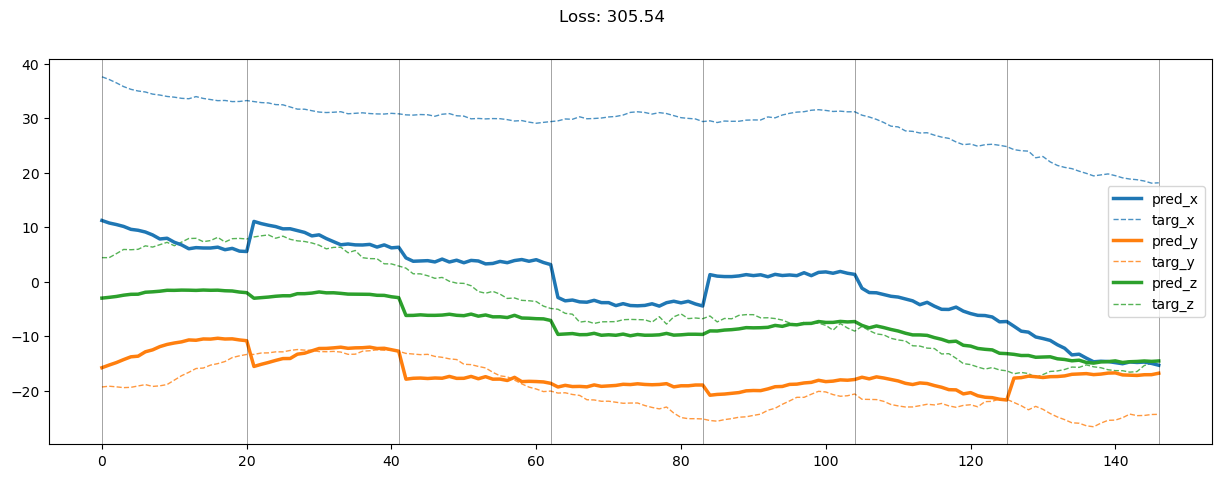

01000: train loss:  178.921, lin acc loss:  1.283, gro loss:  0.212, mag loss:  177.426
       valid loss:  297.282, lin acc loss:  1.160, gro loss:  0.166, mag loss:  295.955
01020: train loss:  179.032, lin acc loss:  1.314, gro loss:  0.204, mag loss:  177.514
       valid loss:  299.119, lin acc loss:  1.161, gro loss:  0.165, mag loss:  297.793
01040: train loss:  185.950, lin acc loss:  1.360, gro loss:  0.217, mag loss:  184.373
       valid loss:  299.446, lin acc loss:  1.161, gro loss:  0.166, mag loss:  298.119
01060: train loss:  173.132, lin acc loss:  1.240, gro loss:  0.198, mag loss:  171.694
       valid loss:  293.282, lin acc loss:  1.160, gro loss:  0.165, mag loss:  291.956
01080: train loss:  157.586, lin acc loss:  1.350, gro loss:  0.211, mag loss:  156.025
       valid loss:  286.443, lin acc loss:  1.160, gro loss:  0.161, mag loss:  285.122
01100: train loss:  155.166, lin acc loss:  1.316, gro loss:  0.214, mag loss:  153.635
       valid loss:  283.901, lin

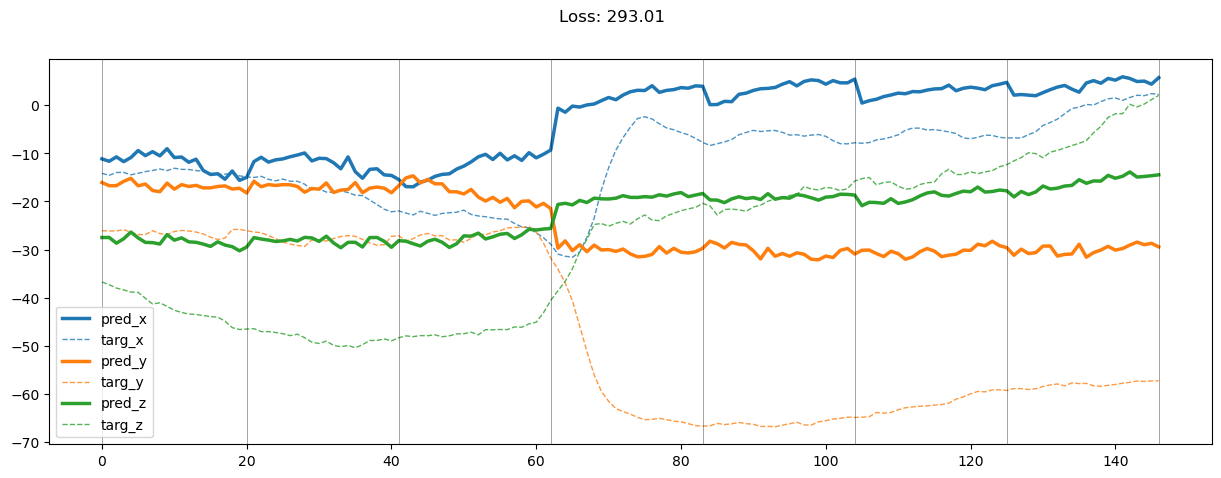

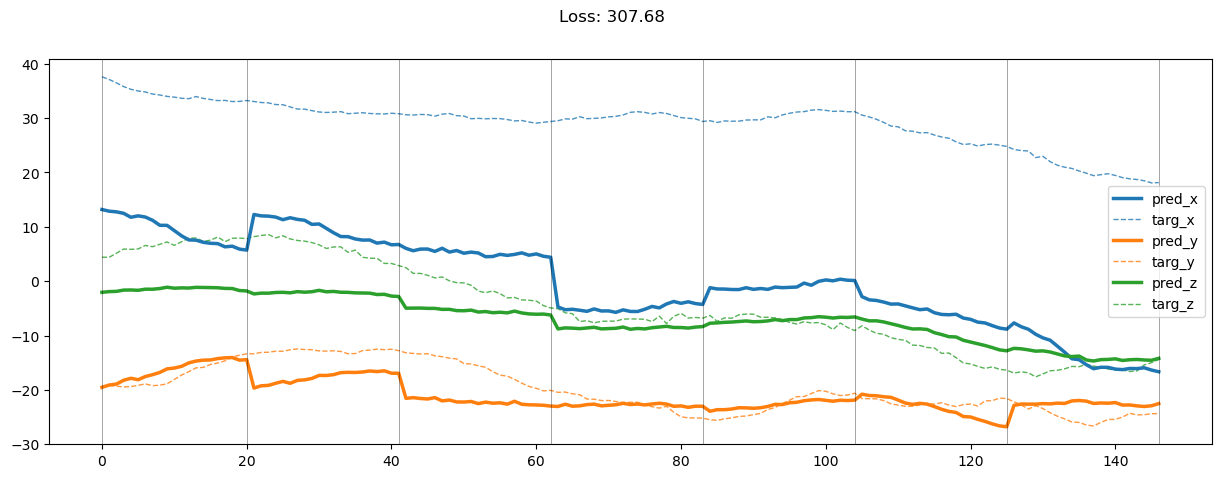

01200: train loss:  126.992, lin acc loss:  1.291, gro loss:  0.199, mag loss:  125.502
       valid loss:  274.562, lin acc loss:  1.161, gro loss:  0.154, mag loss:  273.247
01220: train loss:  129.457, lin acc loss:  1.275, gro loss:  0.205, mag loss:  127.978
       valid loss:  281.700, lin acc loss:  1.161, gro loss:  0.154, mag loss:  280.385
01240: train loss:  117.826, lin acc loss:  1.307, gro loss:  0.203, mag loss:  116.316
       valid loss:  273.610, lin acc loss:  1.162, gro loss:  0.153, mag loss:  272.295
01260: train loss:  99.439, lin acc loss:  1.241, gro loss:  0.180, mag loss:  98.018
       valid loss:  262.874, lin acc loss:  1.164, gro loss:  0.151, mag loss:  261.559
01280: train loss:  104.459, lin acc loss:  1.312, gro loss:  0.194, mag loss:  102.953
       valid loss:  254.912, lin acc loss:  1.163, gro loss:  0.150, mag loss:  253.599
01300: train loss:  110.466, lin acc loss:  1.351, gro loss:  0.196, mag loss:  108.919
       valid loss:  259.039, lin a

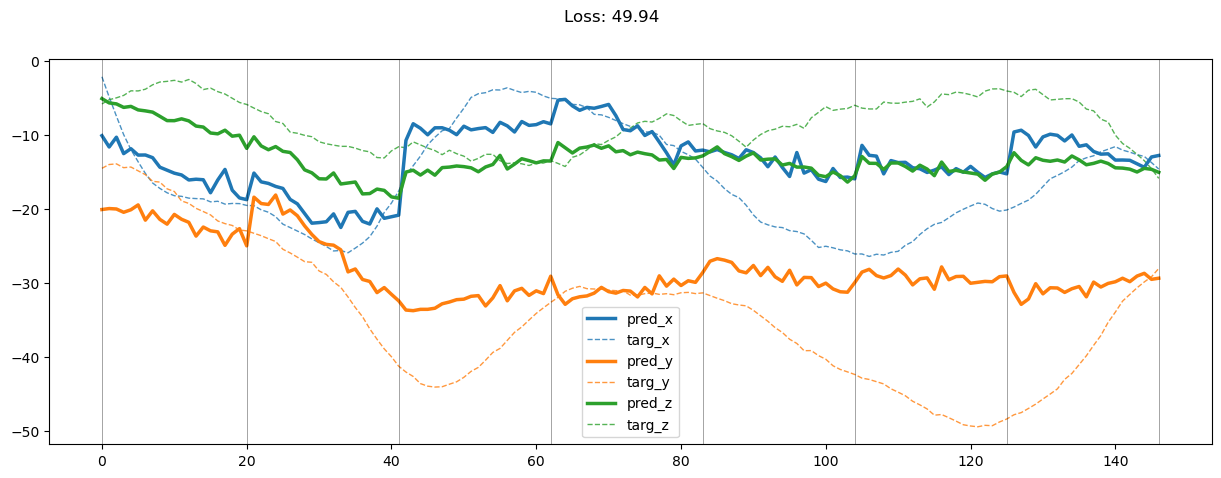

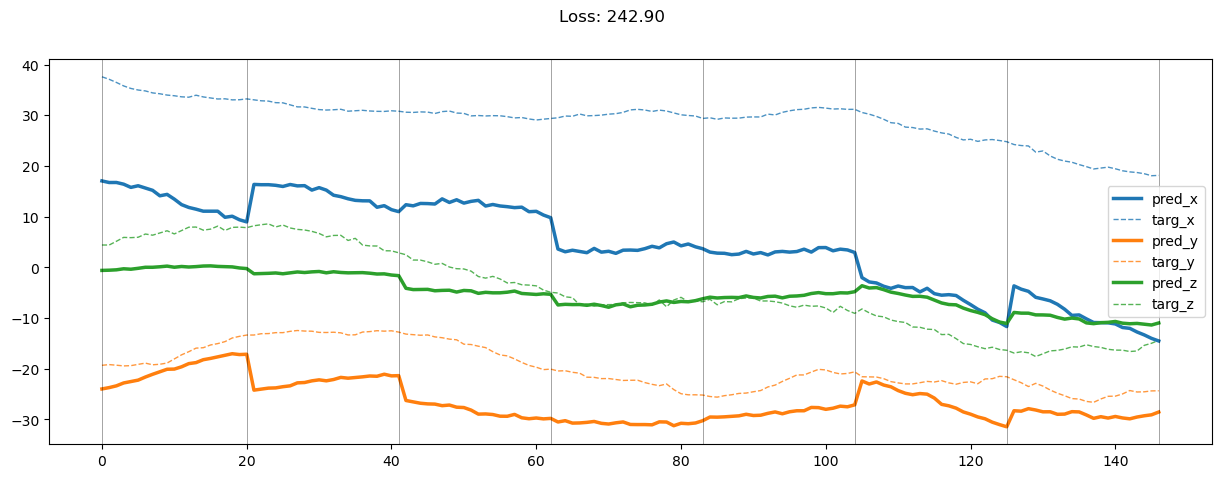

01400: train loss:  75.064, lin acc loss:  1.287, gro loss:  0.193, mag loss:  73.584
       valid loss:  245.490, lin acc loss:  1.162, gro loss:  0.146, mag loss:  244.182
01420: train loss:  76.586, lin acc loss:  1.307, gro loss:  0.199, mag loss:  75.081
       valid loss:  239.939, lin acc loss:  1.164, gro loss:  0.147, mag loss:  238.629
01440: train loss:  75.634, lin acc loss:  1.328, gro loss:  0.185, mag loss:  74.122
       valid loss:  247.524, lin acc loss:  1.165, gro loss:  0.146, mag loss:  246.213
01460: train loss:  73.360, lin acc loss:  1.320, gro loss:  0.191, mag loss:  71.849
       valid loss:  262.237, lin acc loss:  1.164, gro loss:  0.146, mag loss:  260.927
01480: train loss:  72.938, lin acc loss:  1.275, gro loss:  0.175, mag loss:  71.487
       valid loss:  249.666, lin acc loss:  1.164, gro loss:  0.146, mag loss:  248.356
01500: train loss:  66.340, lin acc loss:  1.276, gro loss:  0.185, mag loss:  64.878
       valid loss:  257.017, lin acc loss:  

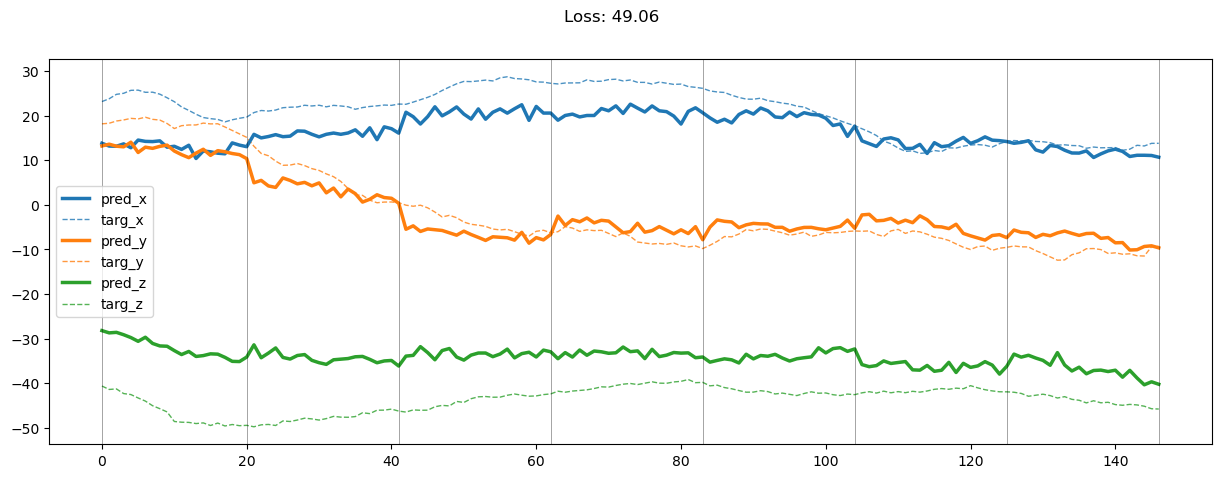

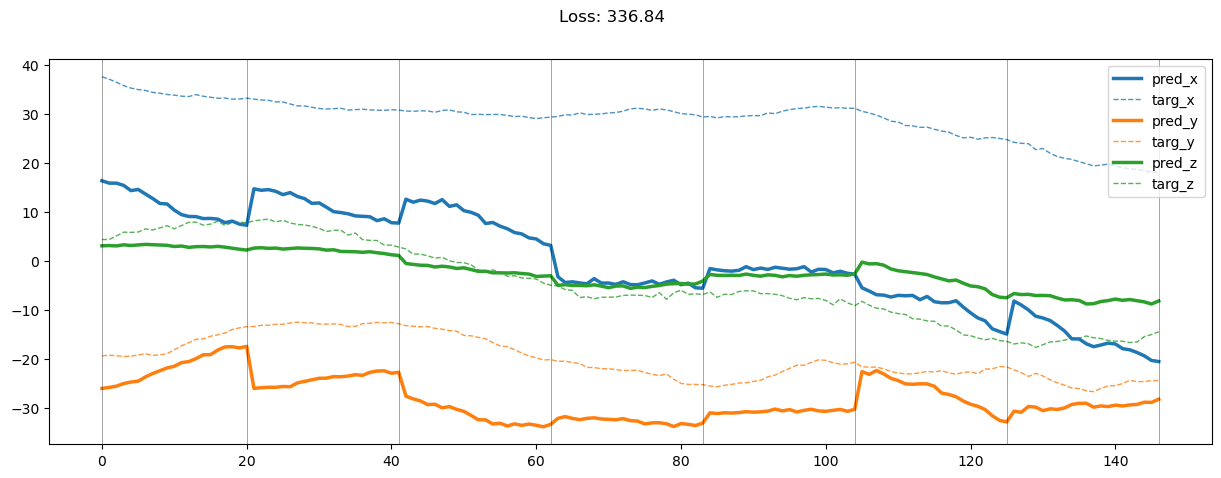

01600: train loss:  56.492, lin acc loss:  1.283, gro loss:  0.198, mag loss:  55.011
       valid loss:  242.124, lin acc loss:  1.167, gro loss:  0.147, mag loss:  240.810
01620: train loss:  52.964, lin acc loss:  1.295, gro loss:  0.185, mag loss:  51.484
       valid loss:  233.909, lin acc loss:  1.165, gro loss:  0.145, mag loss:  232.599
01640: train loss:  49.824, lin acc loss:  1.374, gro loss:  0.204, mag loss:  48.246
       valid loss:  239.411, lin acc loss:  1.166, gro loss:  0.146, mag loss:  238.099
01660: train loss:  45.222, lin acc loss:  1.339, gro loss:  0.193, mag loss:  43.690
       valid loss:  252.151, lin acc loss:  1.166, gro loss:  0.146, mag loss:  250.839
01680: train loss:  47.320, lin acc loss:  1.228, gro loss:  0.182, mag loss:  45.909
       valid loss:  242.635, lin acc loss:  1.168, gro loss:  0.145, mag loss:  241.322
01700: train loss:  40.890, lin acc loss:  1.245, gro loss:  0.174, mag loss:  39.471
       valid loss:  249.070, lin acc loss:  

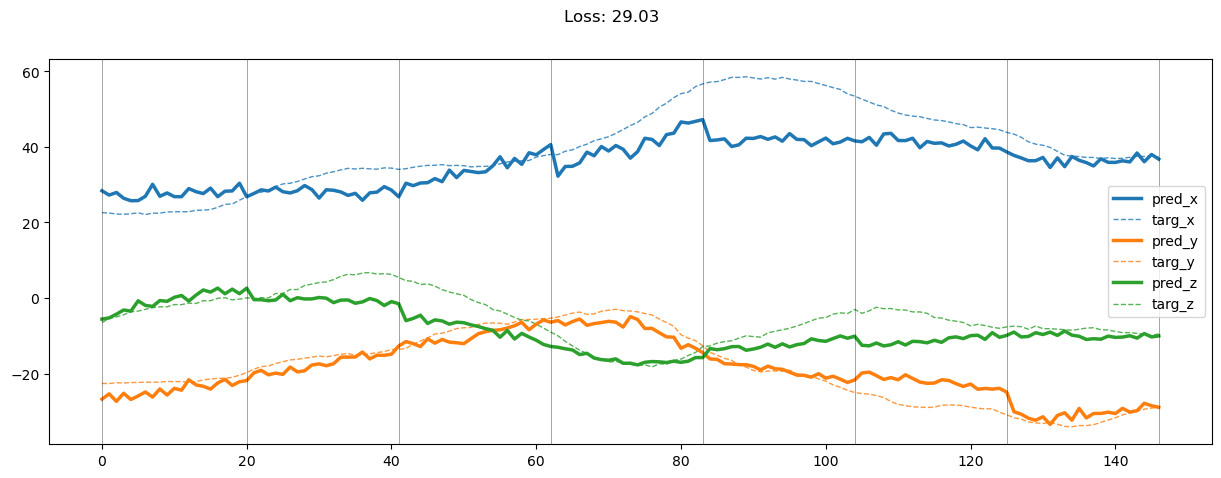

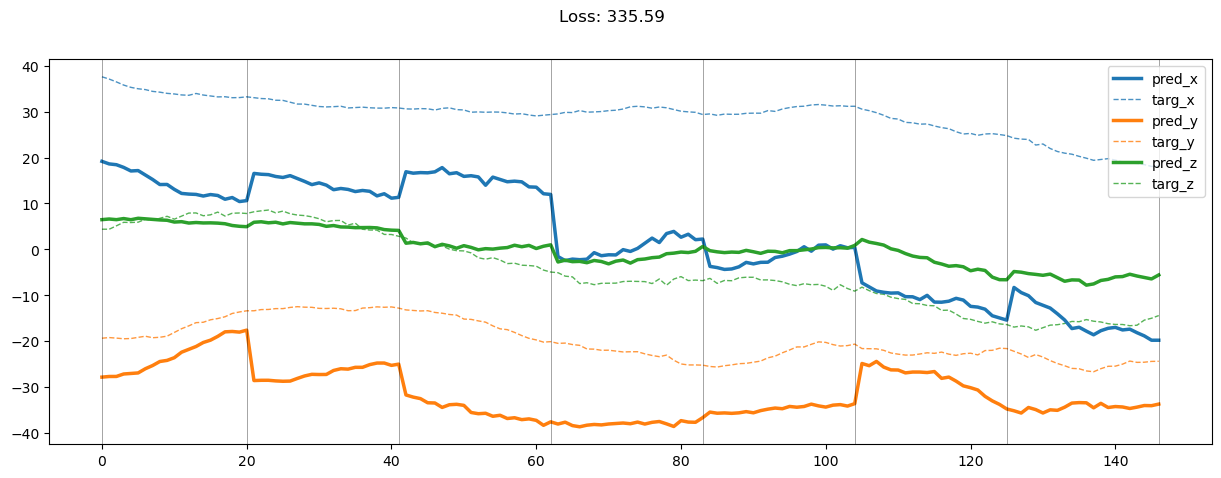

01800: train loss:  36.376, lin acc loss:  1.313, gro loss:  0.177, mag loss:  34.886
       valid loss:  251.951, lin acc loss:  1.166, gro loss:  0.145, mag loss:  250.639
01820: train loss:  30.131, lin acc loss:  1.318, gro loss:  0.194, mag loss:  28.619
       valid loss:  247.122, lin acc loss:  1.166, gro loss:  0.144, mag loss:  245.812
01840: train loss:  33.328, lin acc loss:  1.384, gro loss:  0.196, mag loss:  31.748
       valid loss:  250.321, lin acc loss:  1.163, gro loss:  0.144, mag loss:  249.014
01860: train loss:  30.657, lin acc loss:  1.334, gro loss:  0.177, mag loss:  29.146
       valid loss:  250.096, lin acc loss:  1.164, gro loss:  0.145, mag loss:  248.787
01880: train loss:  29.704, lin acc loss:  1.175, gro loss:  0.160, mag loss:  28.369
       valid loss:  250.734, lin acc loss:  1.165, gro loss:  0.144, mag loss:  249.424
01900: train loss:  28.571, lin acc loss:  1.287, gro loss:  0.186, mag loss:  27.098
       valid loss:  251.888, lin acc loss:  

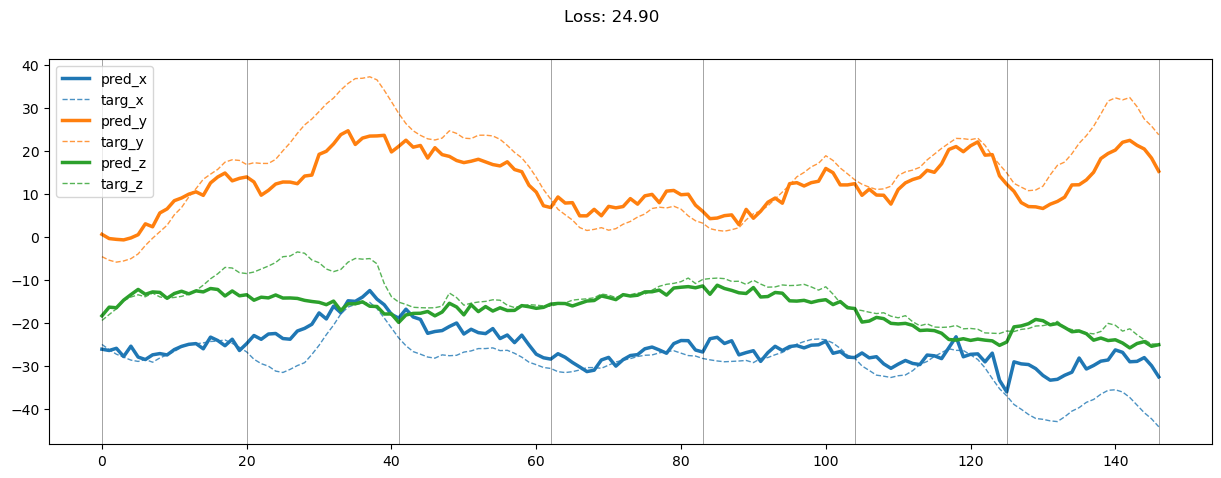

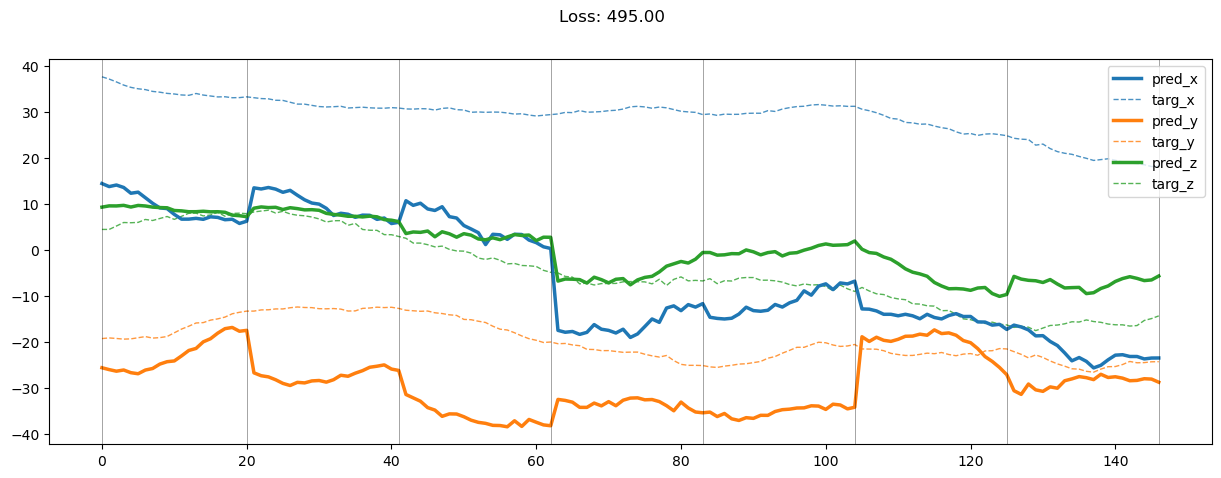

02000: train loss:  21.636, lin acc loss:  1.203, gro loss:  0.163, mag loss:  20.270
       valid loss:  271.564, lin acc loss:  1.162, gro loss:  0.142, mag loss:  270.259
02020: train loss:  23.928, lin acc loss:  1.310, gro loss:  0.182, mag loss:  22.436
       valid loss:  255.743, lin acc loss:  1.163, gro loss:  0.141, mag loss:  254.439
02040: train loss:  21.747, lin acc loss:  1.401, gro loss:  0.185, mag loss:  20.162
       valid loss:  262.363, lin acc loss:  1.162, gro loss:  0.143, mag loss:  261.058
02060: train loss:  19.793, lin acc loss:  1.335, gro loss:  0.179, mag loss:  18.280
       valid loss:  252.710, lin acc loss:  1.163, gro loss:  0.143, mag loss:  251.404
02080: train loss:  20.767, lin acc loss:  1.273, gro loss:  0.176, mag loss:  19.318
       valid loss:  238.802, lin acc loss:  1.161, gro loss:  0.142, mag loss:  237.499
02100: train loss:  19.785, lin acc loss:  1.201, gro loss:  0.158, mag loss:  18.426
       valid loss:  251.577, lin acc loss:  

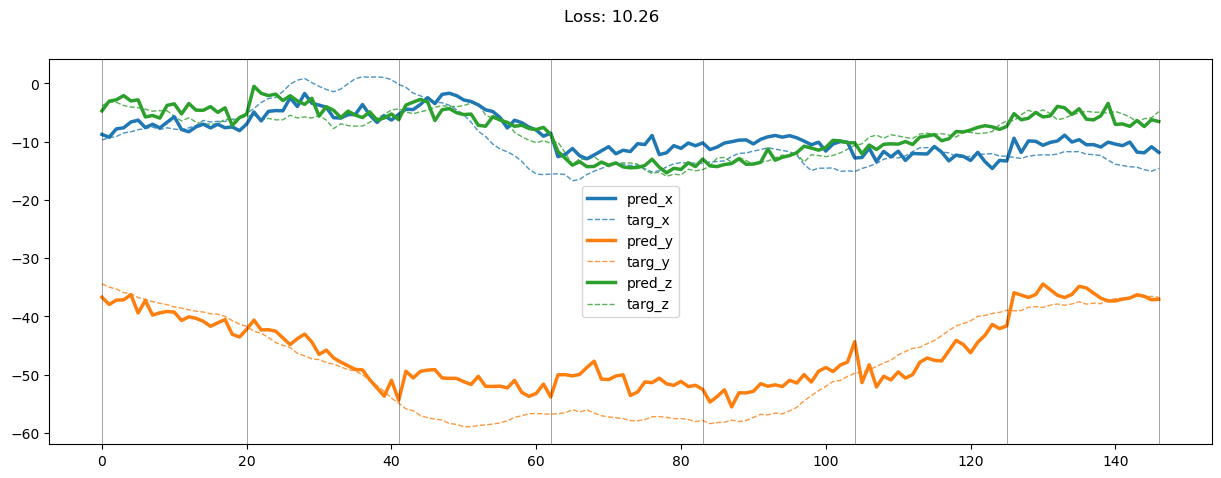

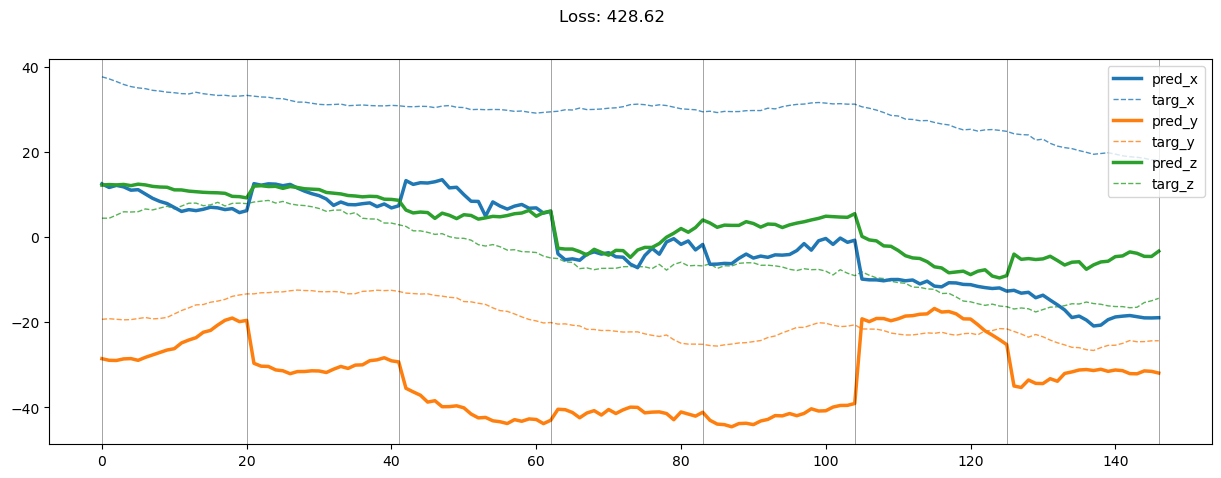

02200: train loss:  18.023, lin acc loss:  1.256, gro loss:  0.174, mag loss:  16.594
       valid loss:  253.560, lin acc loss:  1.161, gro loss:  0.141, mag loss:  252.258
02220: train loss:  16.256, lin acc loss:  1.212, gro loss:  0.162, mag loss:  14.882
       valid loss:  254.732, lin acc loss:  1.160, gro loss:  0.141, mag loss:  253.431
02240: train loss:  15.576, lin acc loss:  1.286, gro loss:  0.169, mag loss:  14.122
       valid loss:  249.999, lin acc loss:  1.160, gro loss:  0.142, mag loss:  248.697
02260: train loss:  13.357, lin acc loss:  1.228, gro loss:  0.157, mag loss:  11.973
       valid loss:  249.887, lin acc loss:  1.160, gro loss:  0.141, mag loss:  248.586
02280: train loss:  15.226, lin acc loss:  1.280, gro loss:  0.179, mag loss:  13.767
       valid loss:  251.174, lin acc loss:  1.160, gro loss:  0.142, mag loss:  249.872
02300: train loss:  15.685, lin acc loss:  1.321, gro loss:  0.187, mag loss:  14.178
       valid loss:  255.951, lin acc loss:  

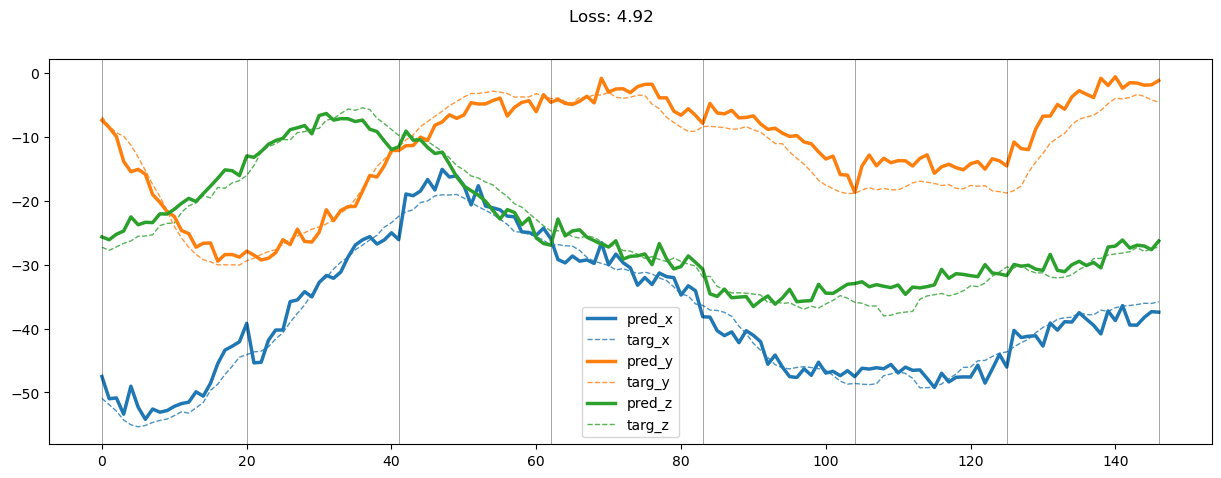

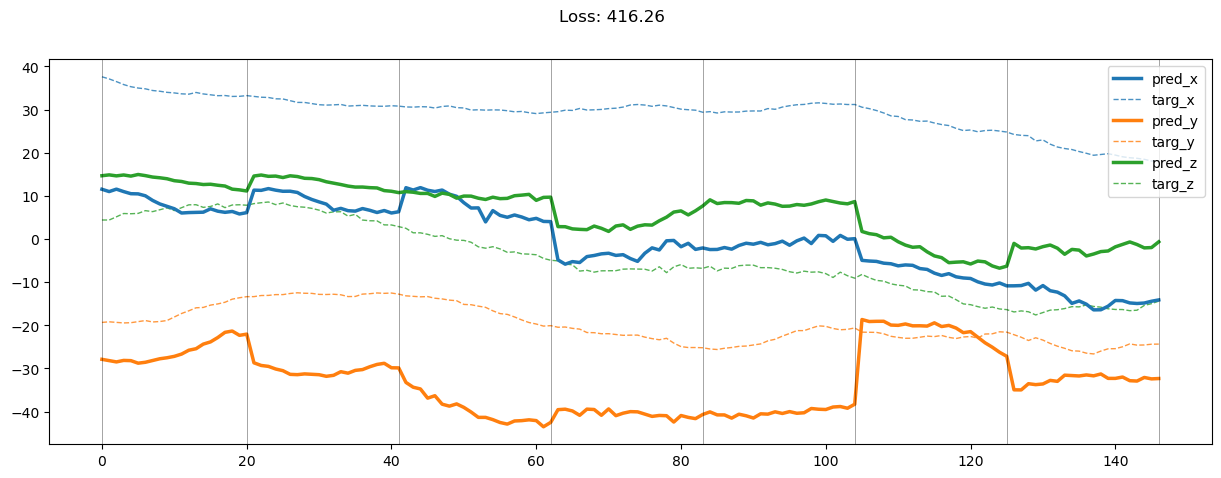

02400: train loss:  11.793, lin acc loss:  1.267, gro loss:  0.177, mag loss:  10.349
       valid loss:  246.476, lin acc loss:  1.159, gro loss:  0.141, mag loss:  245.176
02420: train loss:  11.334, lin acc loss:  1.236, gro loss:  0.173, mag loss:  9.925
       valid loss:  247.812, lin acc loss:  1.159, gro loss:  0.141, mag loss:  246.511
02440: train loss:  11.742, lin acc loss:  1.181, gro loss:  0.167, mag loss:  10.394
       valid loss:  247.788, lin acc loss:  1.158, gro loss:  0.141, mag loss:  246.489
02460: train loss:  10.981, lin acc loss:  1.300, gro loss:  0.180, mag loss:  9.501
       valid loss:  242.185, lin acc loss:  1.158, gro loss:  0.140, mag loss:  240.886
02480: train loss:  13.548, lin acc loss:  1.250, gro loss:  0.172, mag loss:  12.126
       valid loss:  251.793, lin acc loss:  1.158, gro loss:  0.140, mag loss:  250.494
02500: train loss:  12.184, lin acc loss:  1.205, gro loss:  0.174, mag loss:  10.805
       valid loss:  243.238, lin acc loss:  1.

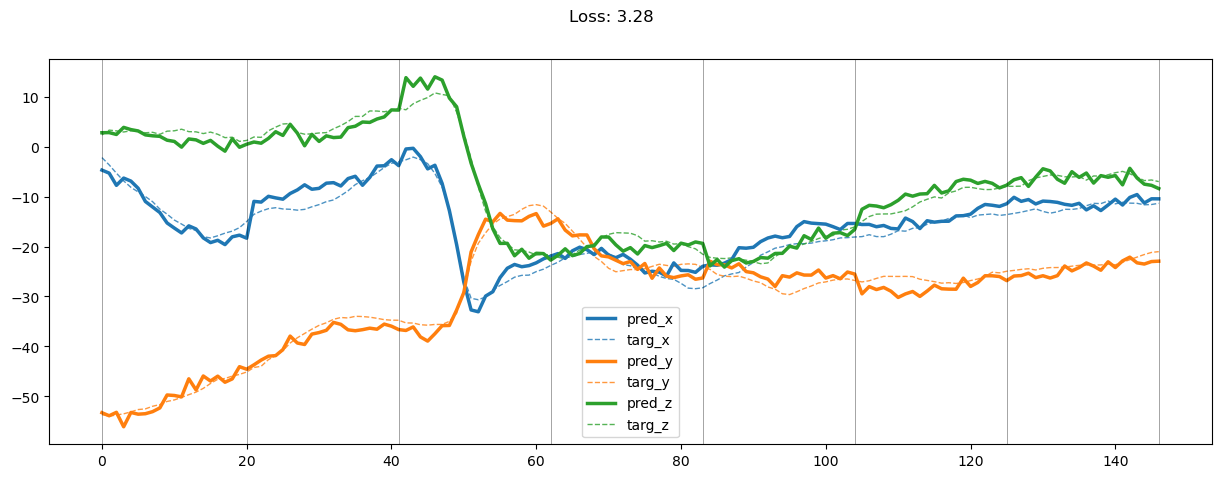

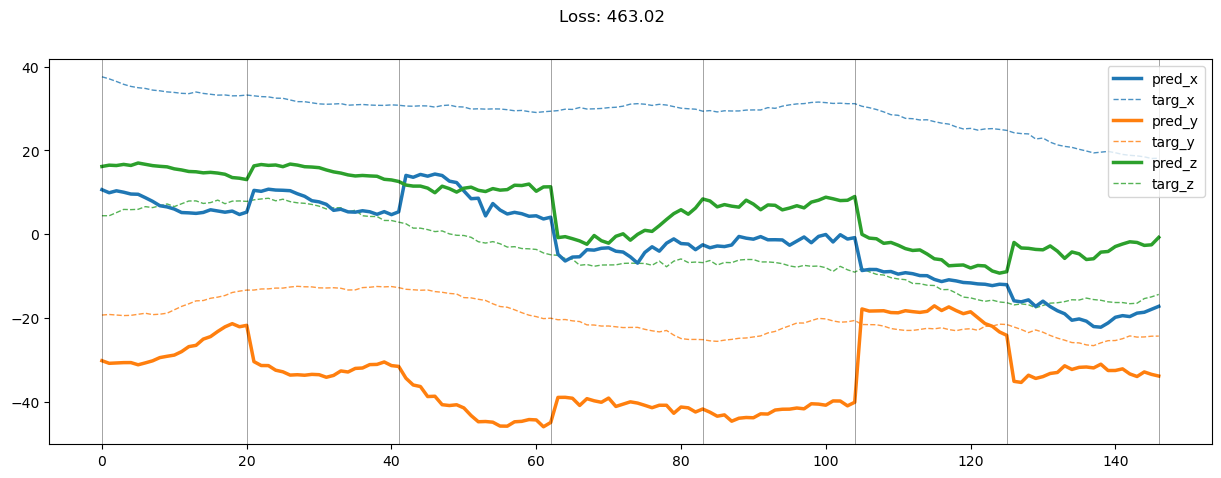

02600: train loss:  10.865, lin acc loss:  1.349, gro loss:  0.179, mag loss:  9.338
       valid loss:  246.034, lin acc loss:  1.159, gro loss:  0.141, mag loss:  244.734
02620: train loss:  9.245, lin acc loss:  1.245, gro loss:  0.178, mag loss:  7.822
       valid loss:  236.583, lin acc loss:  1.159, gro loss:  0.141, mag loss:  235.283
02640: train loss:  9.756, lin acc loss:  1.148, gro loss:  0.161, mag loss:  8.447
       valid loss:  249.725, lin acc loss:  1.158, gro loss:  0.141, mag loss:  248.426
02660: train loss:  9.410, lin acc loss:  1.167, gro loss:  0.163, mag loss:  8.079
       valid loss:  235.852, lin acc loss:  1.157, gro loss:  0.140, mag loss:  234.555
02680: train loss:  10.554, lin acc loss:  1.347, gro loss:  0.185, mag loss:  9.022
       valid loss:  241.766, lin acc loss:  1.157, gro loss:  0.140, mag loss:  240.469
02700: train loss:  9.585, lin acc loss:  1.237, gro loss:  0.173, mag loss:  8.176
       valid loss:  237.522, lin acc loss:  1.156, gro

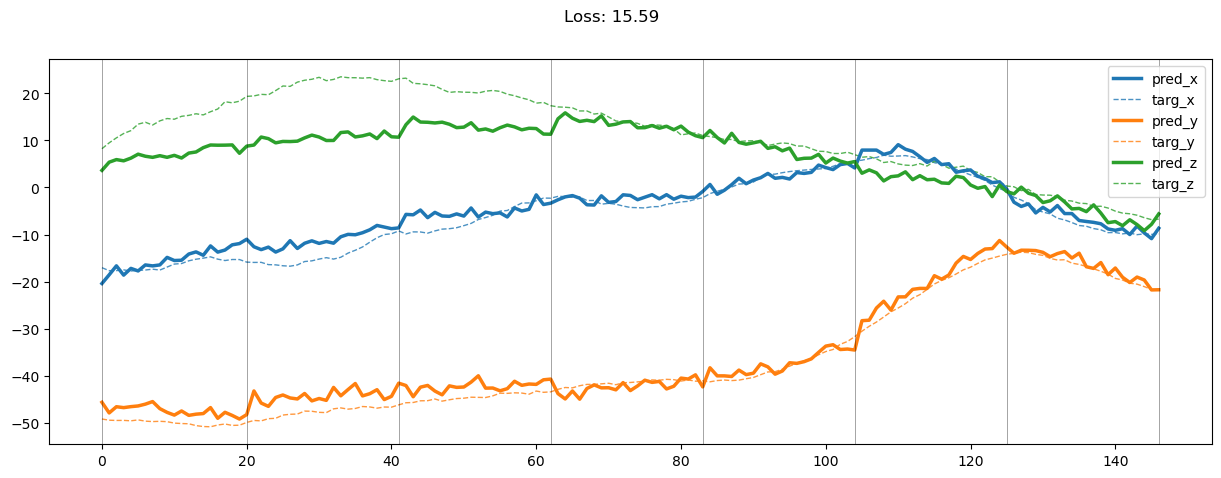

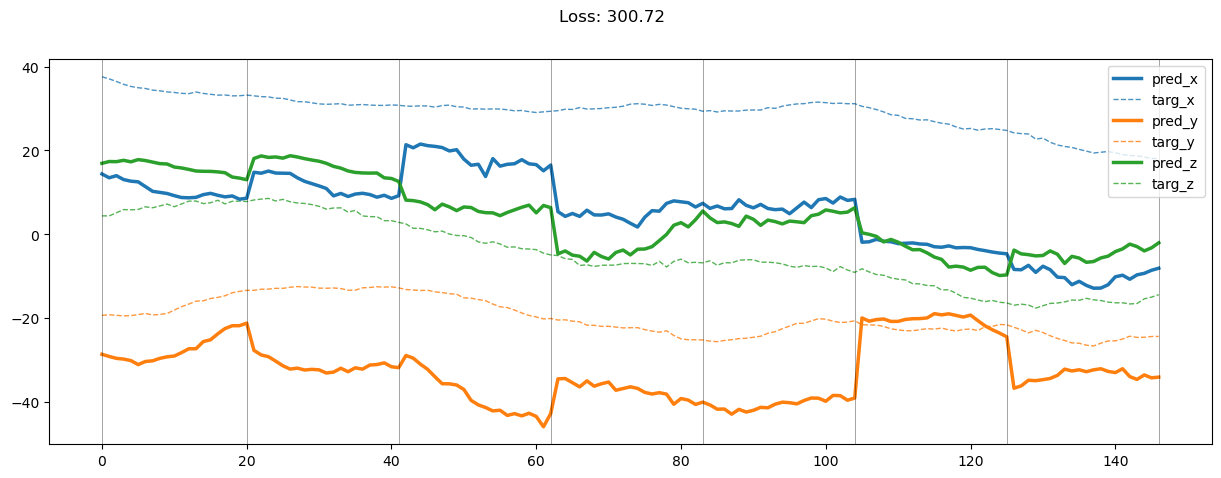

02800: train loss:  8.136, lin acc loss:  1.334, gro loss:  0.180, mag loss:  6.622
       valid loss:  231.750, lin acc loss:  1.156, gro loss:  0.140, mag loss:  230.453
02820: train loss:  8.900, lin acc loss:  1.297, gro loss:  0.172, mag loss:  7.431
       valid loss:  246.058, lin acc loss:  1.156, gro loss:  0.141, mag loss:  244.761
02840: train loss:  8.125, lin acc loss:  1.165, gro loss:  0.154, mag loss:  6.807
       valid loss:  232.130, lin acc loss:  1.157, gro loss:  0.140, mag loss:  230.833
02860: train loss:  8.267, lin acc loss:  1.150, gro loss:  0.155, mag loss:  6.962
       valid loss:  237.385, lin acc loss:  1.156, gro loss:  0.140, mag loss:  236.090
02880: train loss:  8.541, lin acc loss:  1.274, gro loss:  0.183, mag loss:  7.084
       valid loss:  237.111, lin acc loss:  1.156, gro loss:  0.140, mag loss:  235.815
02900: train loss:  8.876, lin acc loss:  1.262, gro loss:  0.175, mag loss:  7.439
       valid loss:  231.074, lin acc loss:  1.156, gro l

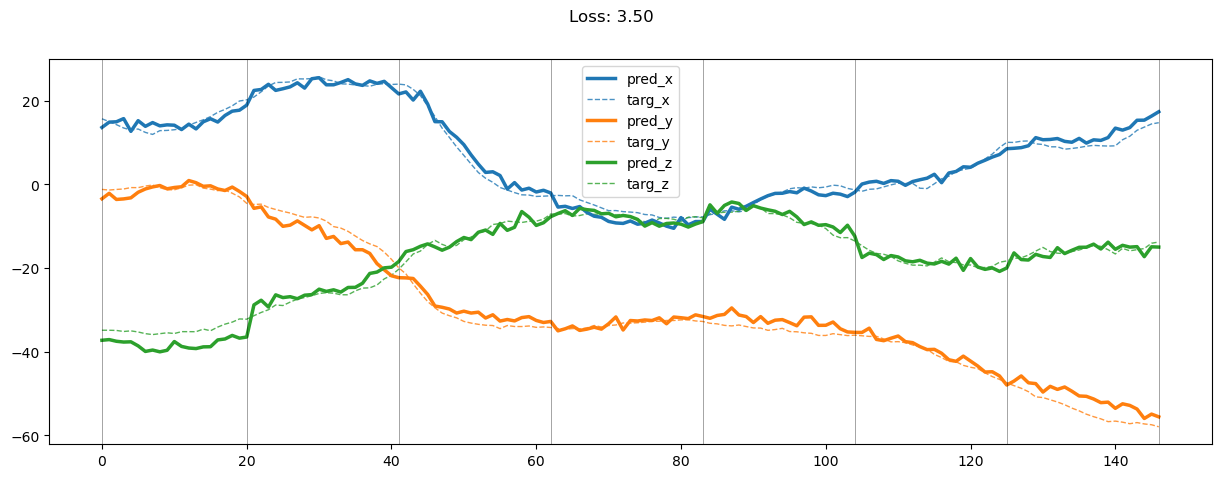

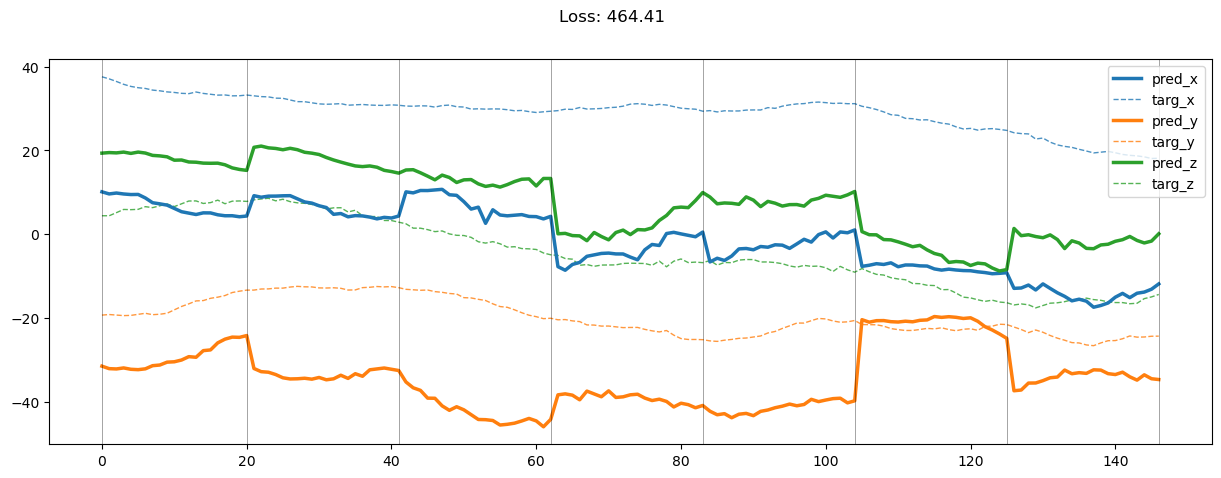

03000: train loss:  6.728, lin acc loss:  1.122, gro loss:  0.159, mag loss:  5.447
       valid loss:  244.922, lin acc loss:  1.155, gro loss:  0.140, mag loss:  243.627
03020: train loss:  8.223, lin acc loss:  1.394, gro loss:  0.191, mag loss:  6.638
       valid loss:  245.283, lin acc loss:  1.156, gro loss:  0.140, mag loss:  243.987
03040: train loss:  7.617, lin acc loss:  1.282, gro loss:  0.179, mag loss:  6.156
       valid loss:  240.873, lin acc loss:  1.155, gro loss:  0.140, mag loss:  239.577
03060: train loss:  7.523, lin acc loss:  1.241, gro loss:  0.164, mag loss:  6.118
       valid loss:  242.024, lin acc loss:  1.155, gro loss:  0.140, mag loss:  240.729
03080: train loss:  7.022, lin acc loss:  1.207, gro loss:  0.166, mag loss:  5.649
       valid loss:  247.877, lin acc loss:  1.155, gro loss:  0.140, mag loss:  246.582
03100: train loss:  6.535, lin acc loss:  1.283, gro loss:  0.175, mag loss:  5.078
       valid loss:  250.596, lin acc loss:  1.155, gro l

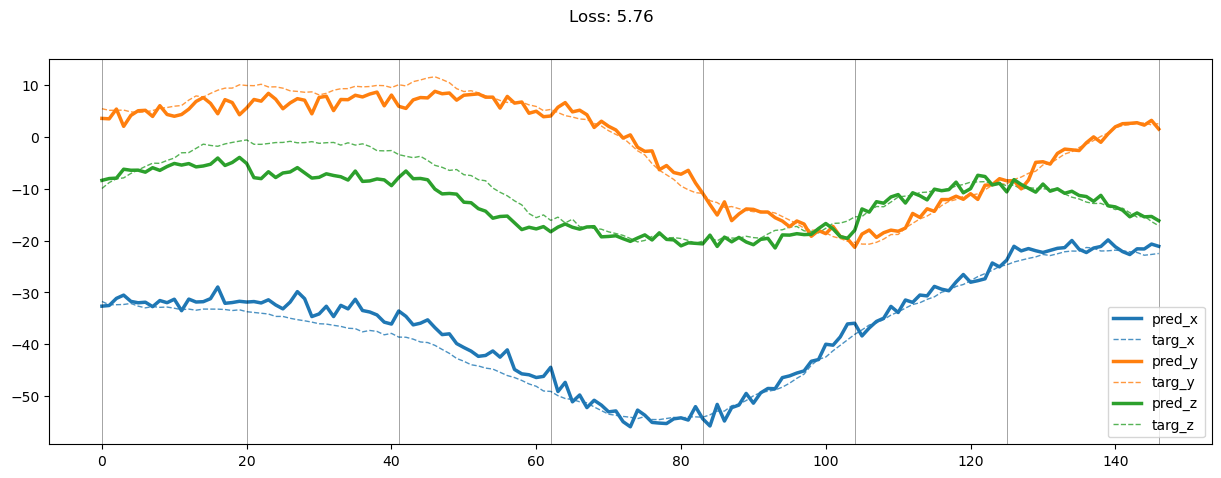

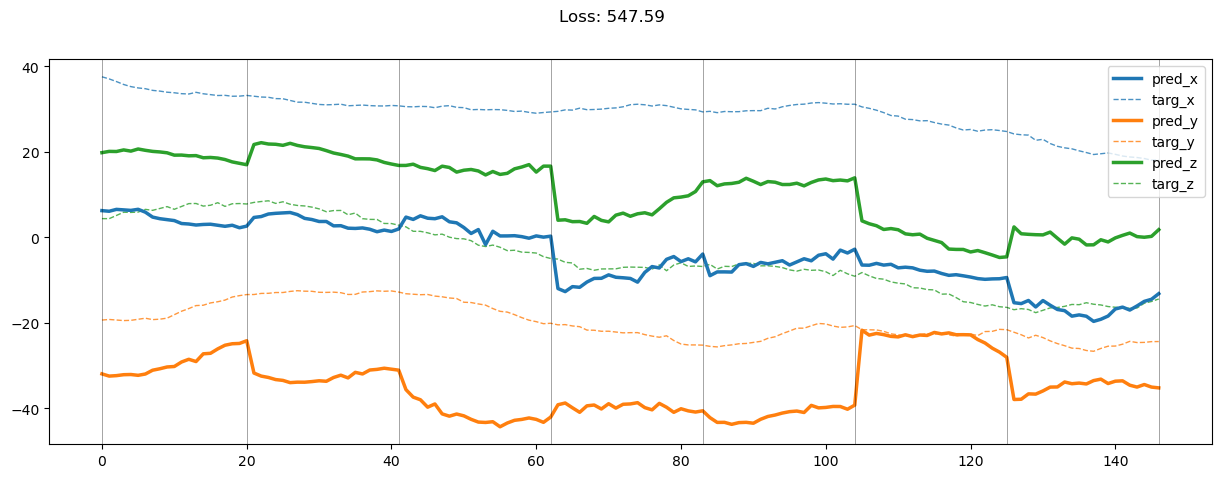

03200: train loss:  6.181, lin acc loss:  1.171, gro loss:  0.147, mag loss:  4.863
       valid loss:  237.891, lin acc loss:  1.155, gro loss:  0.140, mag loss:  236.596
03220: train loss:  6.585, lin acc loss:  1.215, gro loss:  0.163, mag loss:  5.207
       valid loss:  243.421, lin acc loss:  1.156, gro loss:  0.140, mag loss:  242.125
03240: train loss:  6.407, lin acc loss:  1.183, gro loss:  0.162, mag loss:  5.062
       valid loss:  231.980, lin acc loss:  1.154, gro loss:  0.140, mag loss:  230.687
03260: train loss:  5.977, lin acc loss:  1.314, gro loss:  0.173, mag loss:  4.491
       valid loss:  236.971, lin acc loss:  1.155, gro loss:  0.140, mag loss:  235.677
03280: train loss:  6.447, lin acc loss:  1.184, gro loss:  0.158, mag loss:  5.106
       valid loss:  236.556, lin acc loss:  1.155, gro loss:  0.140, mag loss:  235.262
03300: train loss:  6.065, lin acc loss:  1.195, gro loss:  0.153, mag loss:  4.717
       valid loss:  232.022, lin acc loss:  1.155, gro l

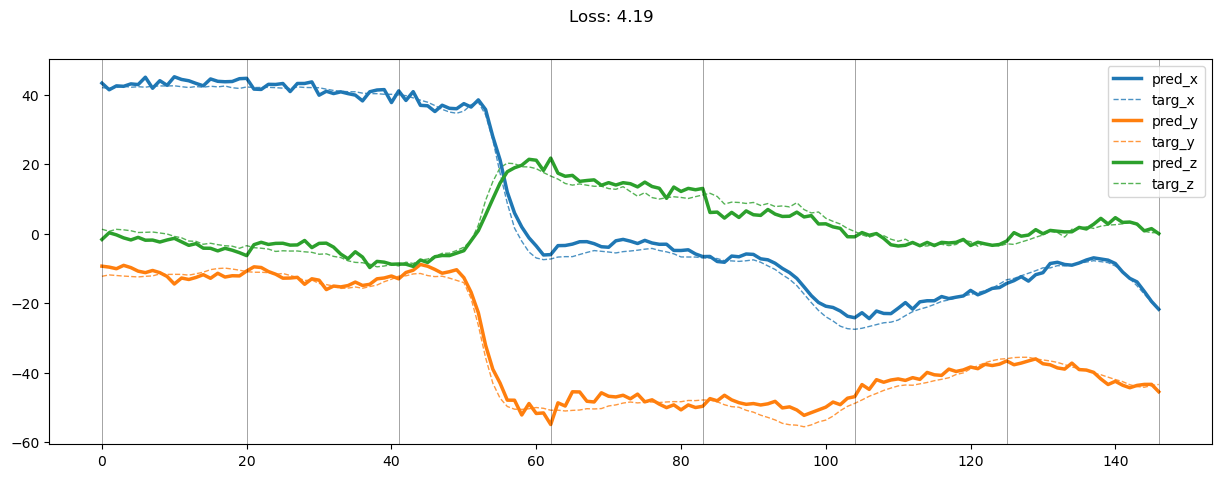

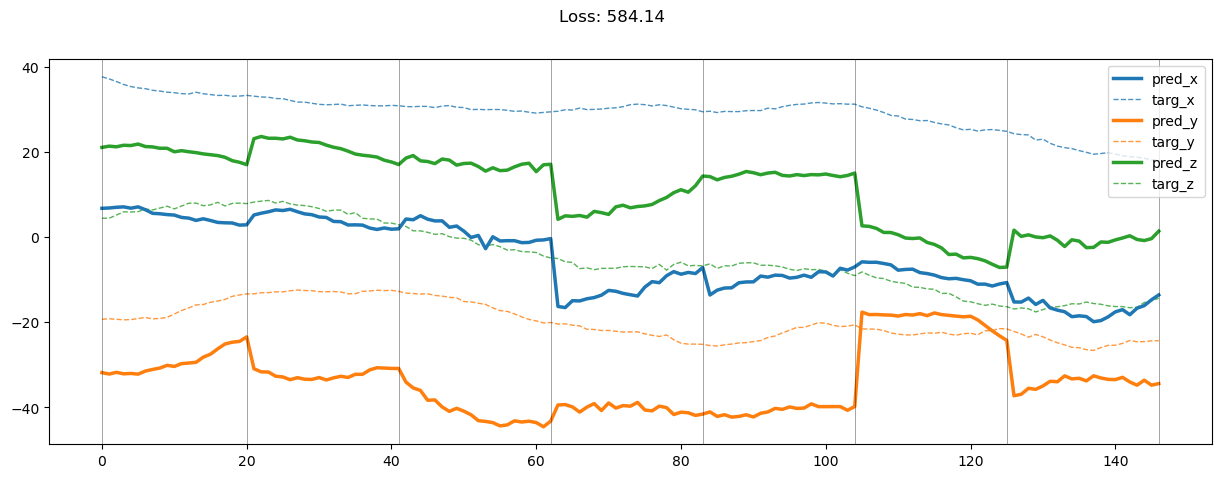

03400: train loss:  5.663, lin acc loss:  1.215, gro loss:  0.166, mag loss:  4.282
       valid loss:  244.475, lin acc loss:  1.155, gro loss:  0.140, mag loss:  243.181
03420: train loss:  5.771, lin acc loss:  1.236, gro loss:  0.167, mag loss:  4.367
       valid loss:  244.820, lin acc loss:  1.155, gro loss:  0.140, mag loss:  243.526
03440: train loss:  5.399, lin acc loss:  1.209, gro loss:  0.157, mag loss:  4.033
       valid loss:  235.037, lin acc loss:  1.156, gro loss:  0.140, mag loss:  233.741
03460: train loss:  5.434, lin acc loss:  1.272, gro loss:  0.167, mag loss:  3.994
       valid loss:  242.309, lin acc loss:  1.156, gro loss:  0.140, mag loss:  241.013
03480: train loss:  5.856, lin acc loss:  1.287, gro loss:  0.187, mag loss:  4.381
       valid loss:  249.896, lin acc loss:  1.156, gro loss:  0.140, mag loss:  248.599
03500: train loss:  5.069, lin acc loss:  1.257, gro loss:  0.157, mag loss:  3.655
       valid loss:  242.211, lin acc loss:  1.156, gro l

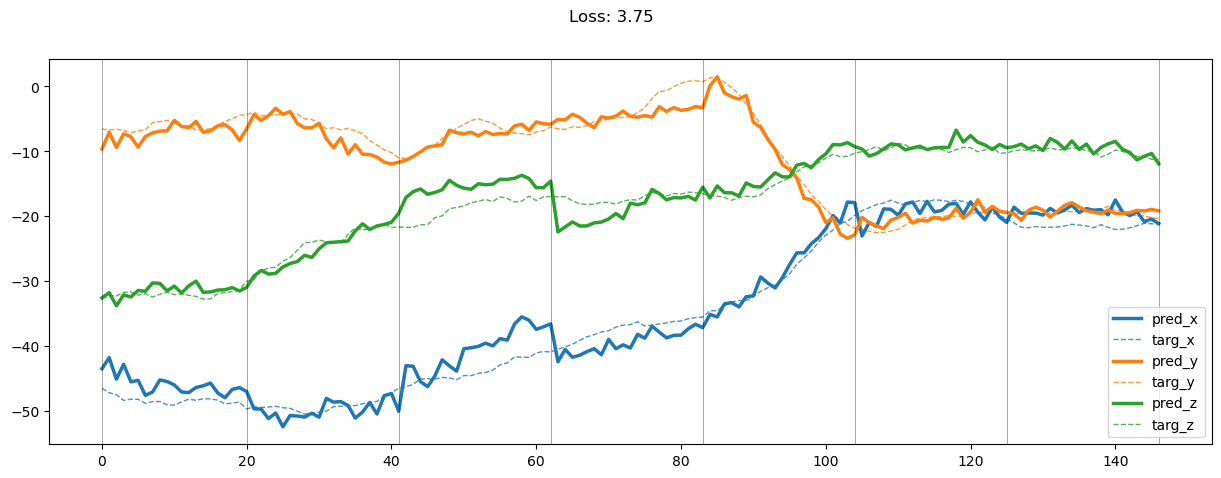

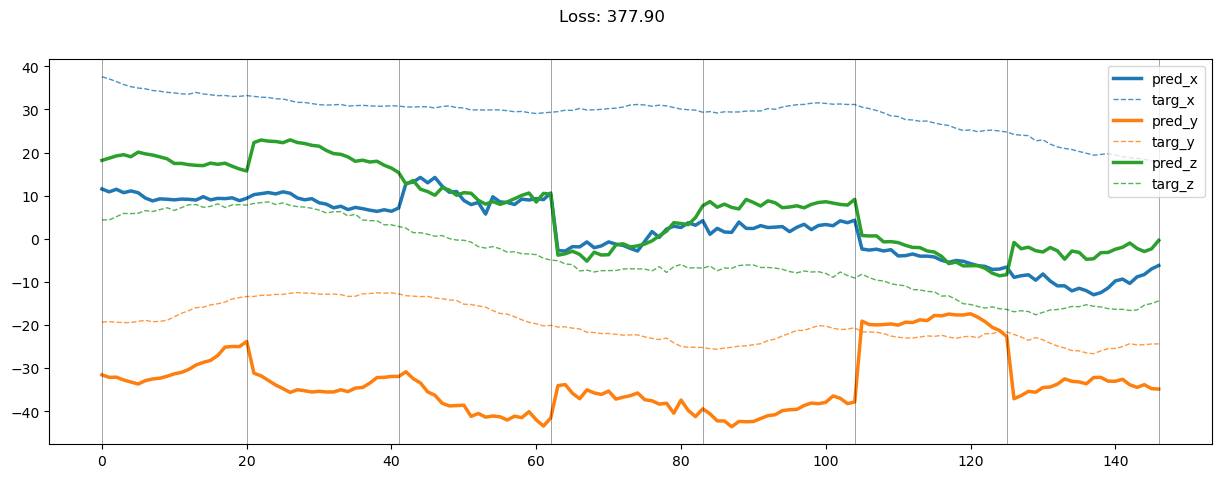

03600: train loss:  5.134, lin acc loss:  1.141, gro loss:  0.148, mag loss:  3.845
       valid loss:  232.351, lin acc loss:  1.155, gro loss:  0.140, mag loss:  231.056
03620: train loss:  5.351, lin acc loss:  1.260, gro loss:  0.165, mag loss:  3.926
       valid loss:  234.381, lin acc loss:  1.155, gro loss:  0.140, mag loss:  233.086
03640: train loss:  5.139, lin acc loss:  1.145, gro loss:  0.158, mag loss:  3.836
       valid loss:  239.009, lin acc loss:  1.156, gro loss:  0.140, mag loss:  237.713
03660: train loss:  4.750, lin acc loss:  1.176, gro loss:  0.157, mag loss:  3.417
       valid loss:  234.176, lin acc loss:  1.156, gro loss:  0.140, mag loss:  232.880
03680: train loss:  4.944, lin acc loss:  1.207, gro loss:  0.161, mag loss:  3.576
       valid loss:  239.330, lin acc loss:  1.158, gro loss:  0.140, mag loss:  238.032
03700: train loss:  4.963, lin acc loss:  1.222, gro loss:  0.174, mag loss:  3.566
       valid loss:  245.494, lin acc loss:  1.156, gro l

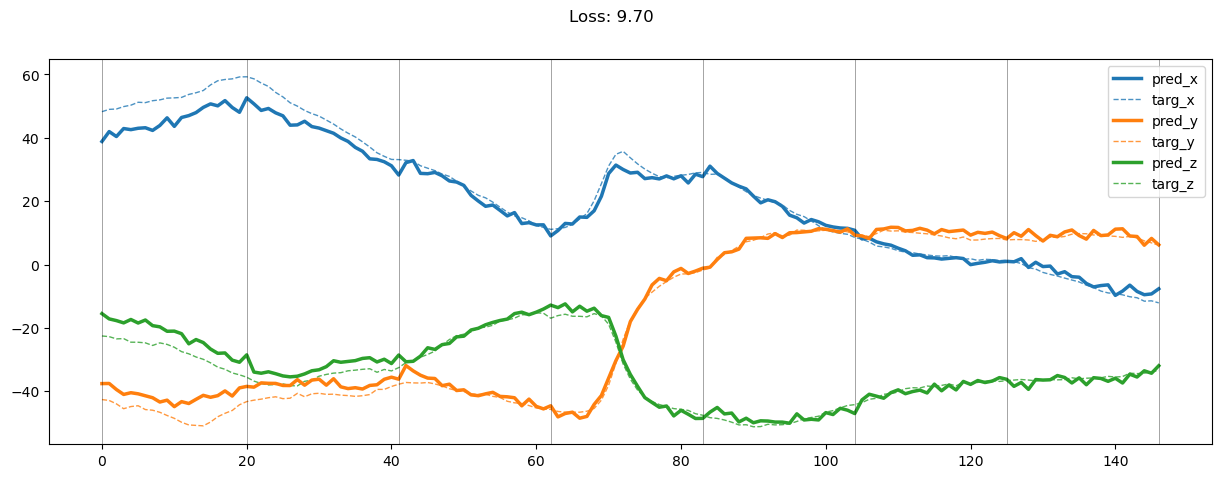

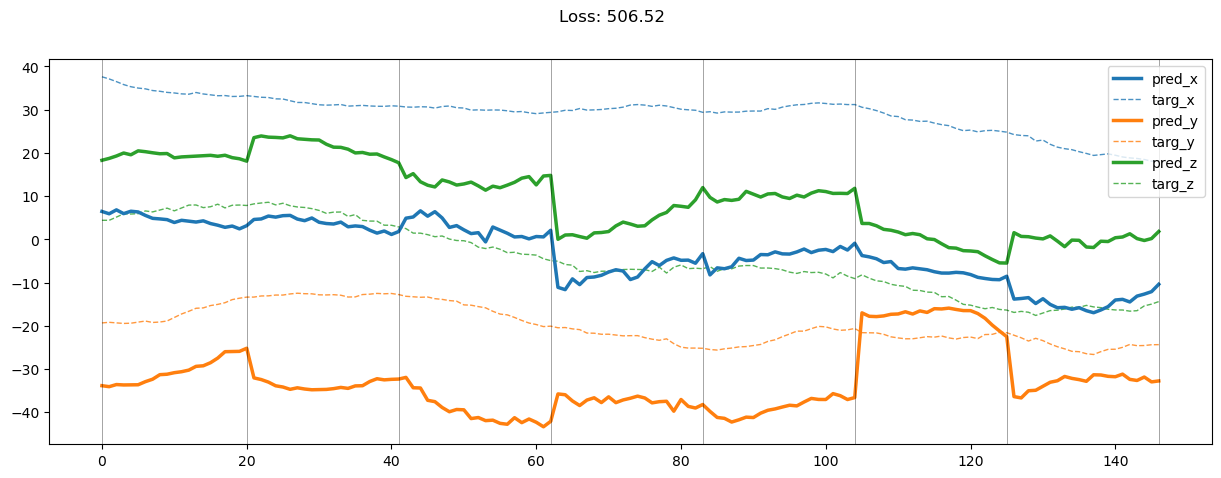

03800: train loss:  4.525, lin acc loss:  1.147, gro loss:  0.151, mag loss:  3.227
       valid loss:  242.917, lin acc loss:  1.158, gro loss:  0.140, mag loss:  241.619
03820: train loss:  4.660, lin acc loss:  1.183, gro loss:  0.147, mag loss:  3.329
       valid loss:  242.813, lin acc loss:  1.158, gro loss:  0.140, mag loss:  241.515
03840: train loss:  4.452, lin acc loss:  1.128, gro loss:  0.155, mag loss:  3.168
       valid loss:  238.852, lin acc loss:  1.161, gro loss:  0.140, mag loss:  237.551
03860: train loss:  4.423, lin acc loss:  1.286, gro loss:  0.172, mag loss:  2.964
       valid loss:  250.312, lin acc loss:  1.160, gro loss:  0.141, mag loss:  249.012
03880: train loss:  4.440, lin acc loss:  1.092, gro loss:  0.151, mag loss:  3.197
       valid loss:  244.847, lin acc loss:  1.159, gro loss:  0.140, mag loss:  243.548
03900: train loss:  4.400, lin acc loss:  1.185, gro loss:  0.158, mag loss:  3.057
       valid loss:  244.030, lin acc loss:  1.159, gro l

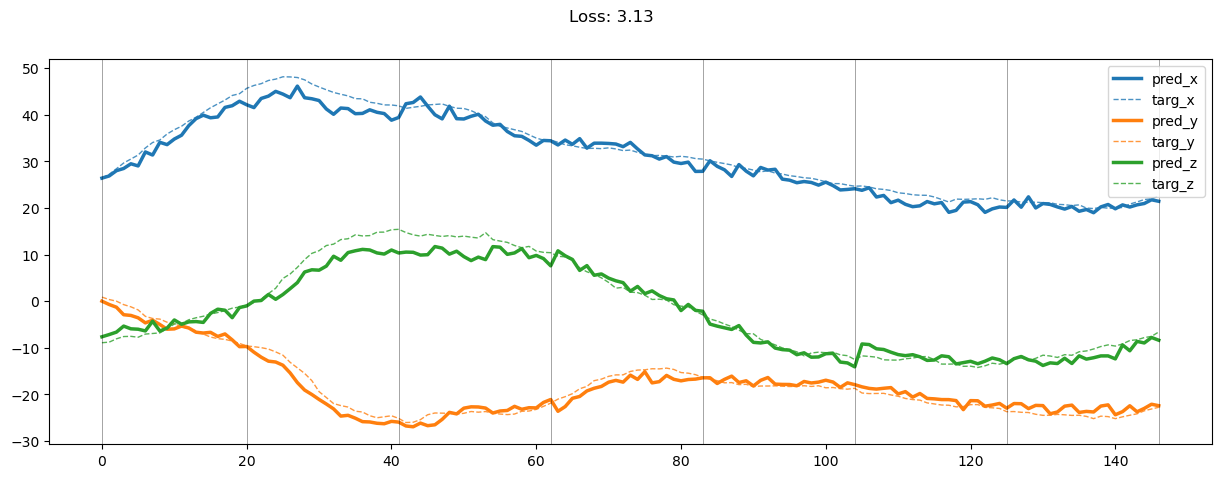

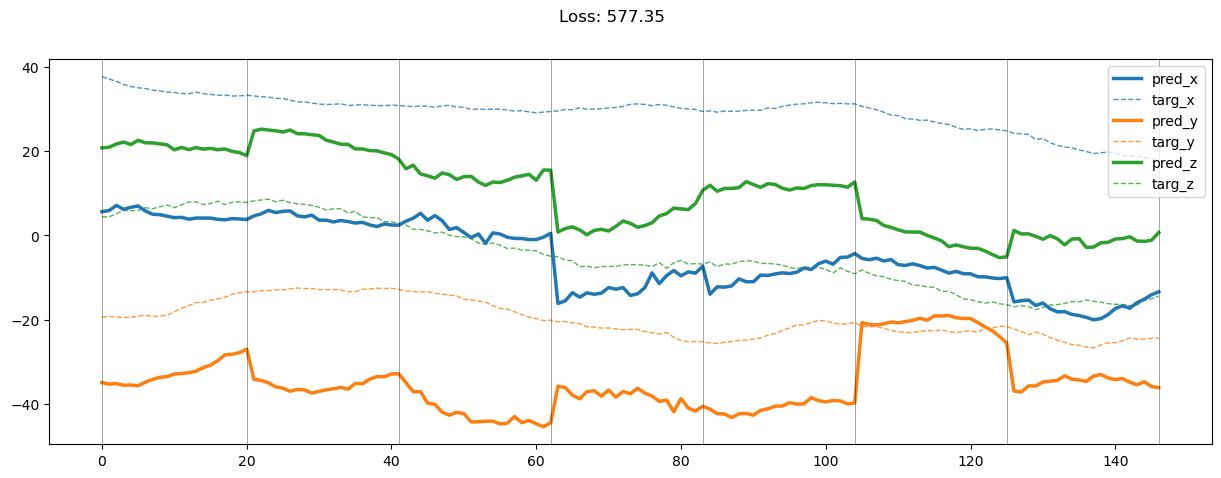

04000: train loss:  4.098, lin acc loss:  1.127, gro loss:  0.152, mag loss:  2.819
       valid loss:  248.545, lin acc loss:  1.161, gro loss:  0.140, mag loss:  247.244
04020: train loss:  4.147, lin acc loss:  1.154, gro loss:  0.163, mag loss:  2.830
       valid loss:  245.827, lin acc loss:  1.163, gro loss:  0.141, mag loss:  244.522
04040: train loss:  4.275, lin acc loss:  1.141, gro loss:  0.160, mag loss:  2.974
       valid loss:  237.741, lin acc loss:  1.163, gro loss:  0.141, mag loss:  236.438
04060: train loss:  4.033, lin acc loss:  1.090, gro loss:  0.156, mag loss:  2.787
       valid loss:  240.493, lin acc loss:  1.161, gro loss:  0.141, mag loss:  239.191
04080: train loss:  4.065, lin acc loss:  1.146, gro loss:  0.158, mag loss:  2.760
       valid loss:  240.169, lin acc loss:  1.165, gro loss:  0.141, mag loss:  238.864
04100: train loss:  4.172, lin acc loss:  1.113, gro loss:  0.147, mag loss:  2.912
       valid loss:  241.797, lin acc loss:  1.164, gro l

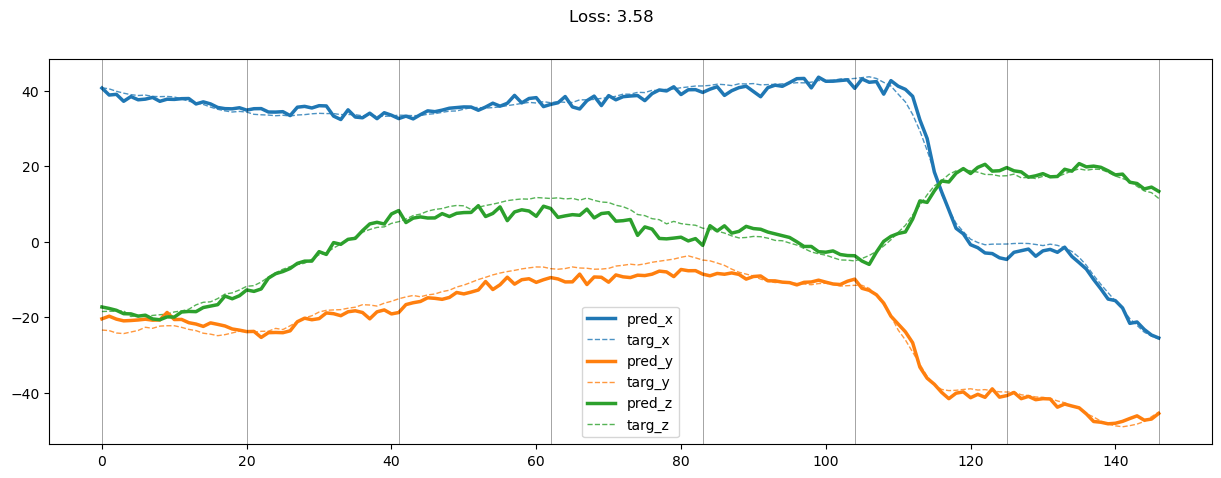

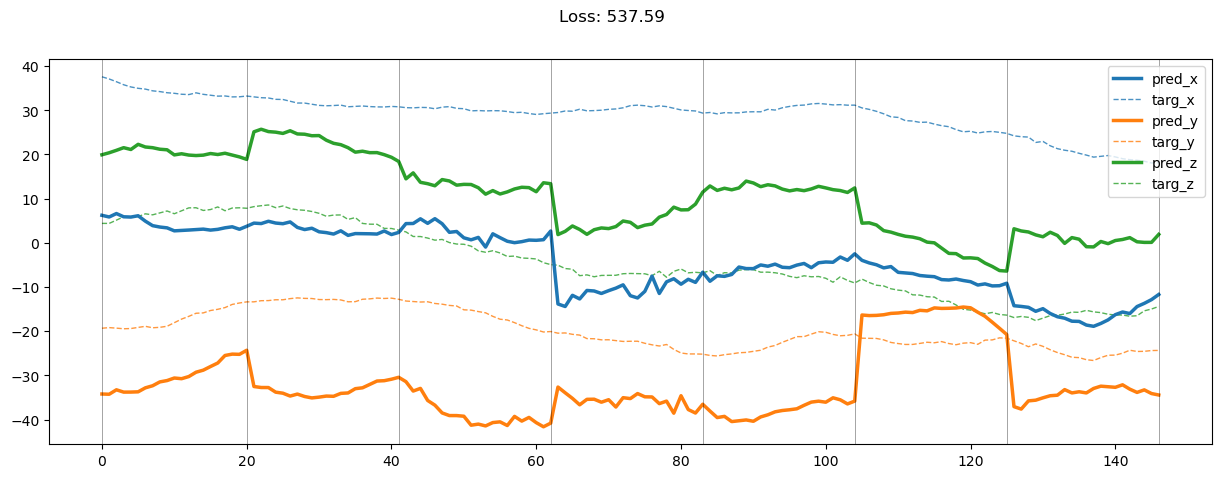

04200: train loss:  3.861, lin acc loss:  1.115, gro loss:  0.147, mag loss:  2.599
       valid loss:  237.147, lin acc loss:  1.169, gro loss:  0.141, mag loss:  235.837
04220: train loss:  3.725, lin acc loss:  1.092, gro loss:  0.132, mag loss:  2.501
       valid loss:  241.070, lin acc loss:  1.169, gro loss:  0.142, mag loss:  239.758
04240: train loss:  3.810, lin acc loss:  1.077, gro loss:  0.156, mag loss:  2.576
       valid loss:  234.122, lin acc loss:  1.170, gro loss:  0.141, mag loss:  232.811
04260: train loss:  3.789, lin acc loss:  1.079, gro loss:  0.151, mag loss:  2.559
       valid loss:  239.841, lin acc loss:  1.172, gro loss:  0.142, mag loss:  238.527
04280: train loss:  3.758, lin acc loss:  1.092, gro loss:  0.150, mag loss:  2.516
       valid loss:  233.118, lin acc loss:  1.171, gro loss:  0.141, mag loss:  231.806
04300: train loss:  3.861, lin acc loss:  1.088, gro loss:  0.167, mag loss:  2.606
       valid loss:  241.677, lin acc loss:  1.176, gro l

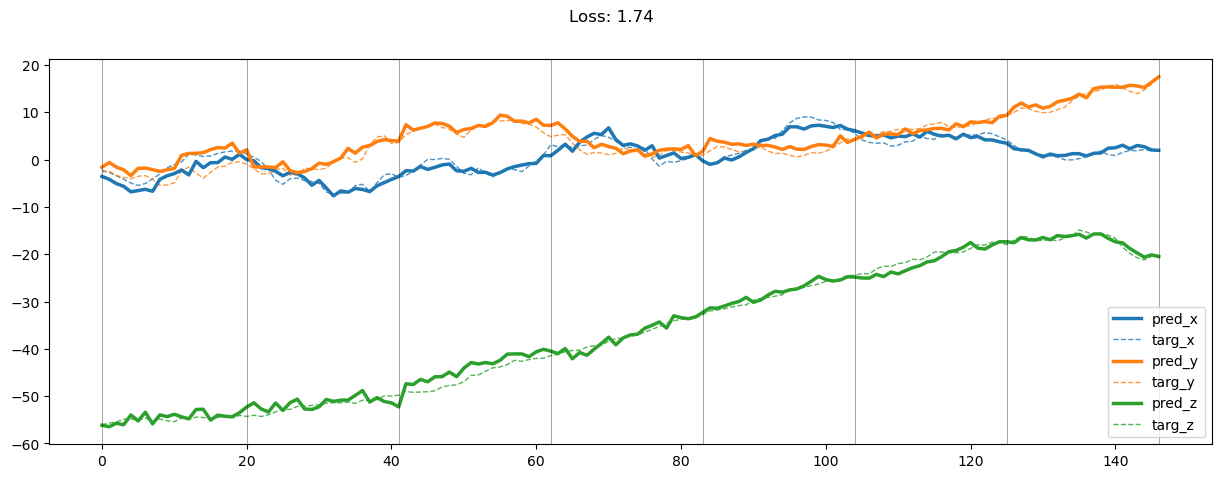

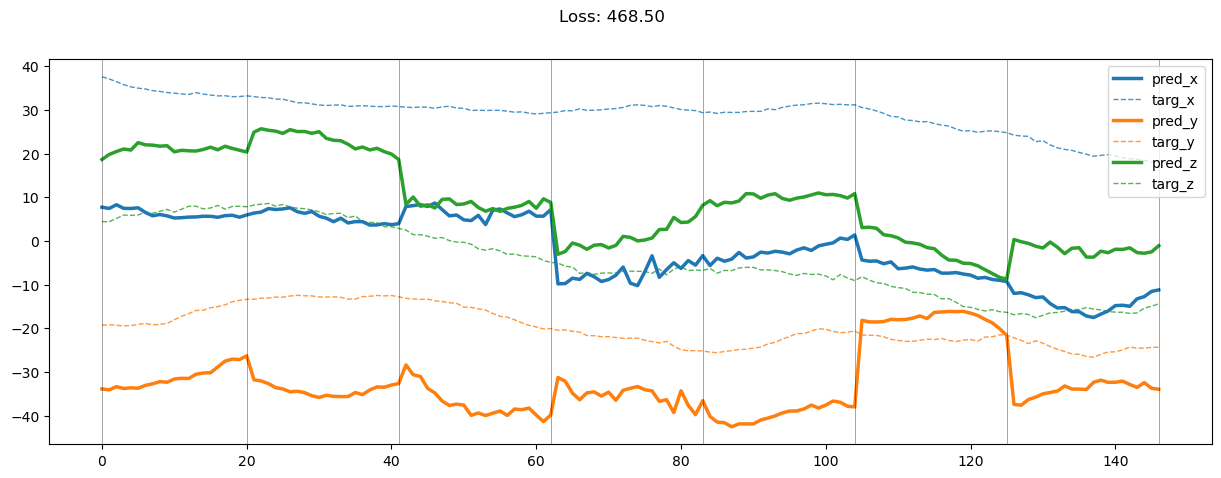

04400: train loss:  3.615, lin acc loss:  1.100, gro loss:  0.150, mag loss:  2.365
       valid loss:  233.725, lin acc loss:  1.186, gro loss:  0.142, mag loss:  232.397
04420: train loss:  3.575, lin acc loss:  1.036, gro loss:  0.146, mag loss:  2.393
       valid loss:  229.575, lin acc loss:  1.181, gro loss:  0.142, mag loss:  228.252
04440: train loss:  3.641, lin acc loss:  1.048, gro loss:  0.151, mag loss:  2.442
       valid loss:  239.704, lin acc loss:  1.183, gro loss:  0.142, mag loss:  238.379
04460: train loss:  3.414, lin acc loss:  1.006, gro loss:  0.148, mag loss:  2.260
       valid loss:  240.355, lin acc loss:  1.189, gro loss:  0.142, mag loss:  239.024
04480: train loss:  3.716, lin acc loss:  1.044, gro loss:  0.136, mag loss:  2.537
       valid loss:  240.964, lin acc loss:  1.186, gro loss:  0.142, mag loss:  239.636
04500: train loss:  3.647, lin acc loss:  1.092, gro loss:  0.145, mag loss:  2.410
       valid loss:  232.430, lin acc loss:  1.188, gro l

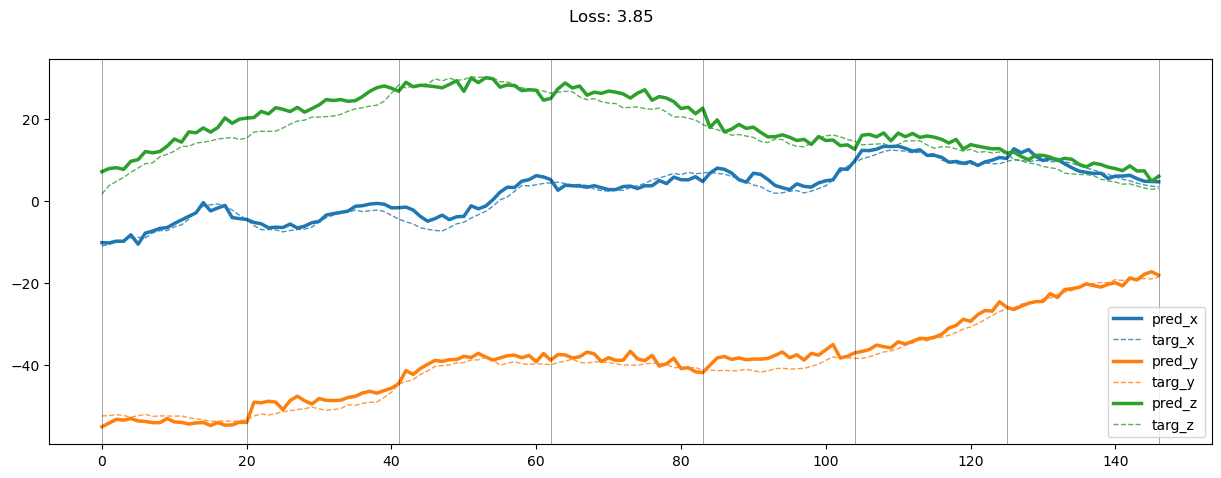

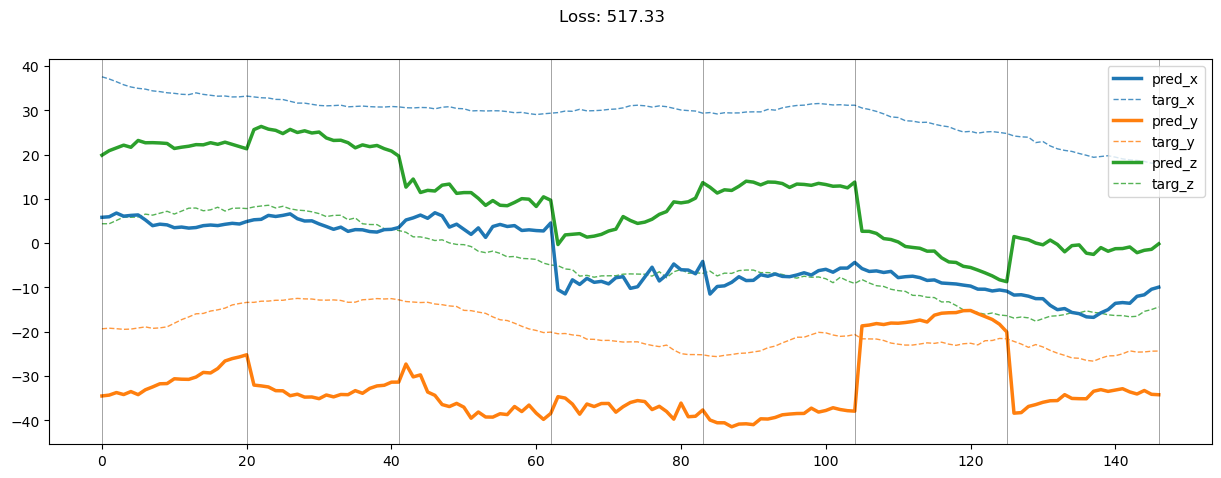

04600: train loss:  3.642, lin acc loss:  1.010, gro loss:  0.151, mag loss:  2.480
       valid loss:  242.006, lin acc loss:  1.205, gro loss:  0.143, mag loss:  240.658
04620: train loss:  3.430, lin acc loss:  1.014, gro loss:  0.142, mag loss:  2.274
       valid loss:  250.398, lin acc loss:  1.206, gro loss:  0.144, mag loss:  249.048
04640: train loss:  3.446, lin acc loss:  1.042, gro loss:  0.159, mag loss:  2.245
       valid loss:  238.076, lin acc loss:  1.203, gro loss:  0.143, mag loss:  236.731
04660: train loss:  3.380, lin acc loss:  1.008, gro loss:  0.150, mag loss:  2.223
       valid loss:  241.650, lin acc loss:  1.213, gro loss:  0.143, mag loss:  240.294
04680: train loss:  3.351, lin acc loss:  1.008, gro loss:  0.153, mag loss:  2.189
       valid loss:  234.725, lin acc loss:  1.216, gro loss:  0.143, mag loss:  233.366
04700: train loss:  3.215, lin acc loss:  0.984, gro loss:  0.153, mag loss:  2.077
       valid loss:  247.113, lin acc loss:  1.216, gro l

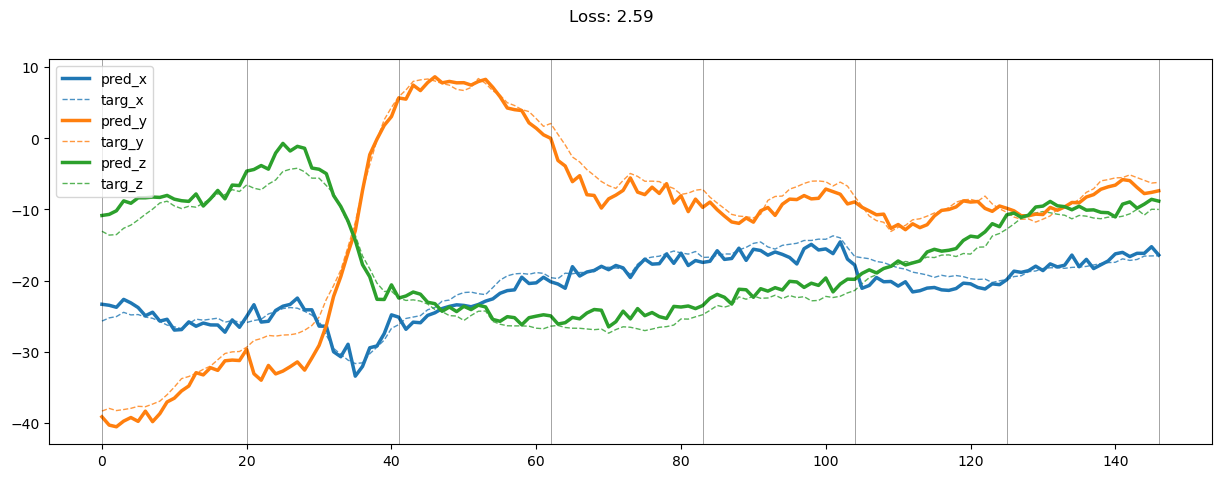

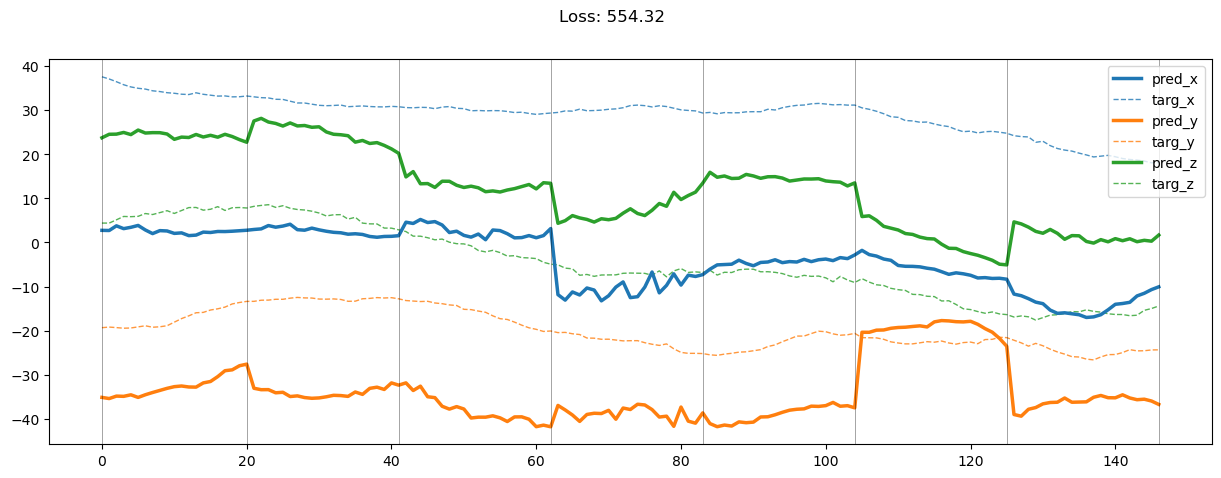

04800: train loss:  3.097, lin acc loss:  0.894, gro loss:  0.146, mag loss:  2.057
       valid loss:  239.040, lin acc loss:  1.236, gro loss:  0.144, mag loss:  237.661
04820: train loss:  3.254, lin acc loss:  0.955, gro loss:  0.147, mag loss:  2.152
       valid loss:  243.880, lin acc loss:  1.226, gro loss:  0.144, mag loss:  242.509
04840: train loss:  3.201, lin acc loss:  0.925, gro loss:  0.146, mag loss:  2.130
       valid loss:  249.593, lin acc loss:  1.240, gro loss:  0.144, mag loss:  248.208
04860: train loss:  3.064, lin acc loss:  0.910, gro loss:  0.148, mag loss:  2.006
       valid loss:  239.516, lin acc loss:  1.243, gro loss:  0.144, mag loss:  238.129
04880: train loss:  3.049, lin acc loss:  0.912, gro loss:  0.138, mag loss:  1.999
       valid loss:  241.884, lin acc loss:  1.250, gro loss:  0.145, mag loss:  240.490
04900: train loss:  3.081, lin acc loss:  0.869, gro loss:  0.140, mag loss:  2.072
       valid loss:  228.574, lin acc loss:  1.257, gro l

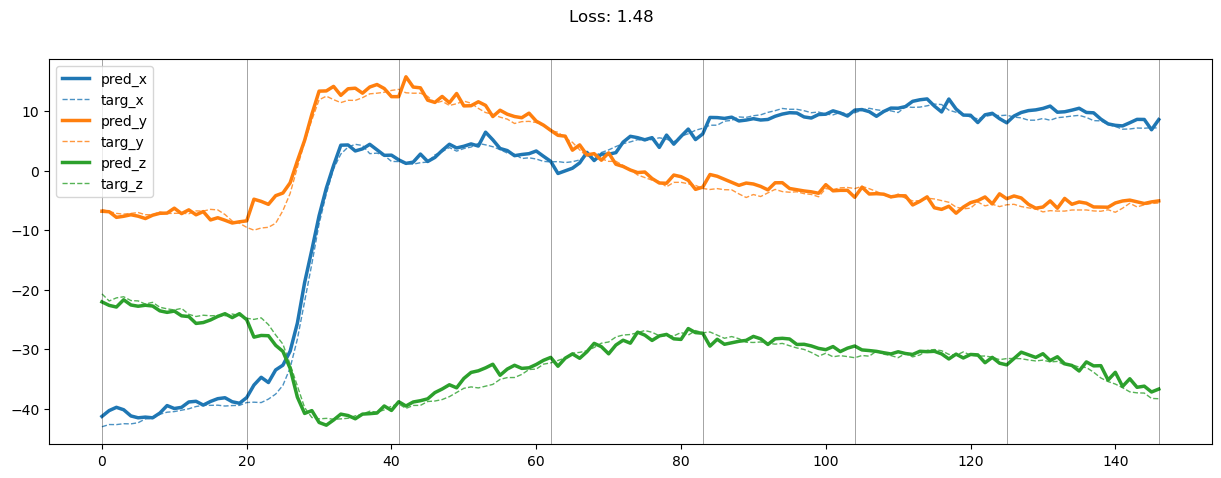

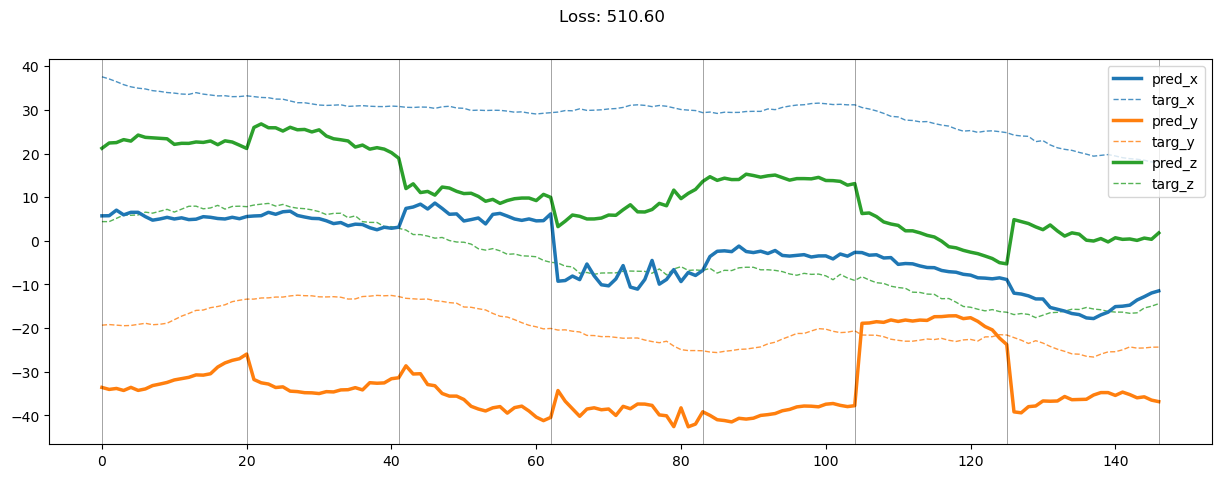

05000: train loss:  2.819, lin acc loss:  0.826, gro loss:  0.135, mag loss:  1.859
       valid loss:  238.906, lin acc loss:  1.271, gro loss:  0.146, mag loss:  237.489
05020: train loss:  2.937, lin acc loss:  0.844, gro loss:  0.144, mag loss:  1.950
       valid loss:  234.252, lin acc loss:  1.286, gro loss:  0.145, mag loss:  232.821
05040: train loss:  2.995, lin acc loss:  0.904, gro loss:  0.137, mag loss:  1.954
       valid loss:  232.331, lin acc loss:  1.287, gro loss:  0.146, mag loss:  230.898
05060: train loss:  2.771, lin acc loss:  0.802, gro loss:  0.145, mag loss:  1.823
       valid loss:  231.300, lin acc loss:  1.286, gro loss:  0.145, mag loss:  229.869
05080: train loss:  2.849, lin acc loss:  0.814, gro loss:  0.140, mag loss:  1.894
       valid loss:  238.951, lin acc loss:  1.297, gro loss:  0.146, mag loss:  237.507
05100: train loss:  2.703, lin acc loss:  0.813, gro loss:  0.139, mag loss:  1.751
       valid loss:  231.935, lin acc loss:  1.305, gro l

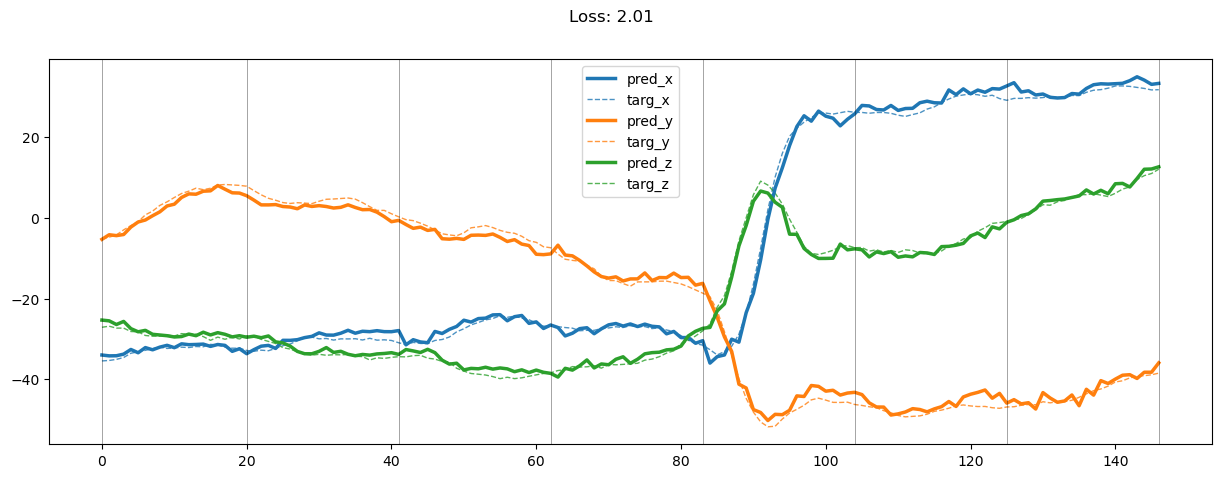

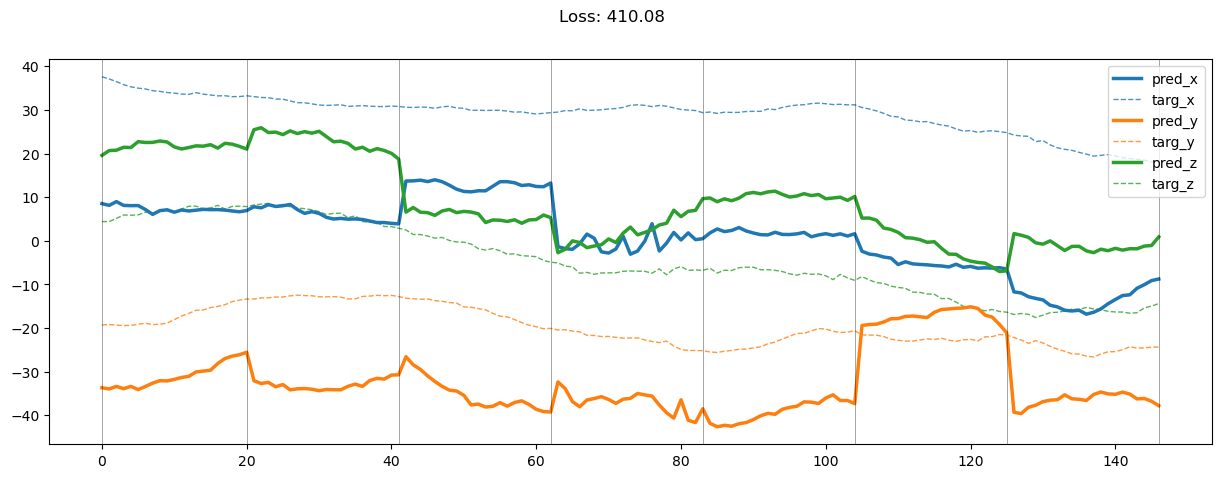

05200: train loss:  2.748, lin acc loss:  0.762, gro loss:  0.134, mag loss:  1.853
       valid loss:  234.146, lin acc loss:  1.333, gro loss:  0.147, mag loss:  232.666
05220: train loss:  2.524, lin acc loss:  0.724, gro loss:  0.128, mag loss:  1.673
       valid loss:  233.101, lin acc loss:  1.332, gro loss:  0.148, mag loss:  231.620
05240: train loss:  2.677, lin acc loss:  0.767, gro loss:  0.133, mag loss:  1.777
       valid loss:  241.097, lin acc loss:  1.363, gro loss:  0.149, mag loss:  239.586
05260: train loss:  2.617, lin acc loss:  0.761, gro loss:  0.129, mag loss:  1.726
       valid loss:  225.734, lin acc loss:  1.348, gro loss:  0.148, mag loss:  224.238
05280: train loss:  2.681, lin acc loss:  0.734, gro loss:  0.133, mag loss:  1.813
       valid loss:  230.504, lin acc loss:  1.347, gro loss:  0.148, mag loss:  229.008
05300: train loss:  2.763, lin acc loss:  0.719, gro loss:  0.131, mag loss:  1.913
       valid loss:  231.423, lin acc loss:  1.352, gro l

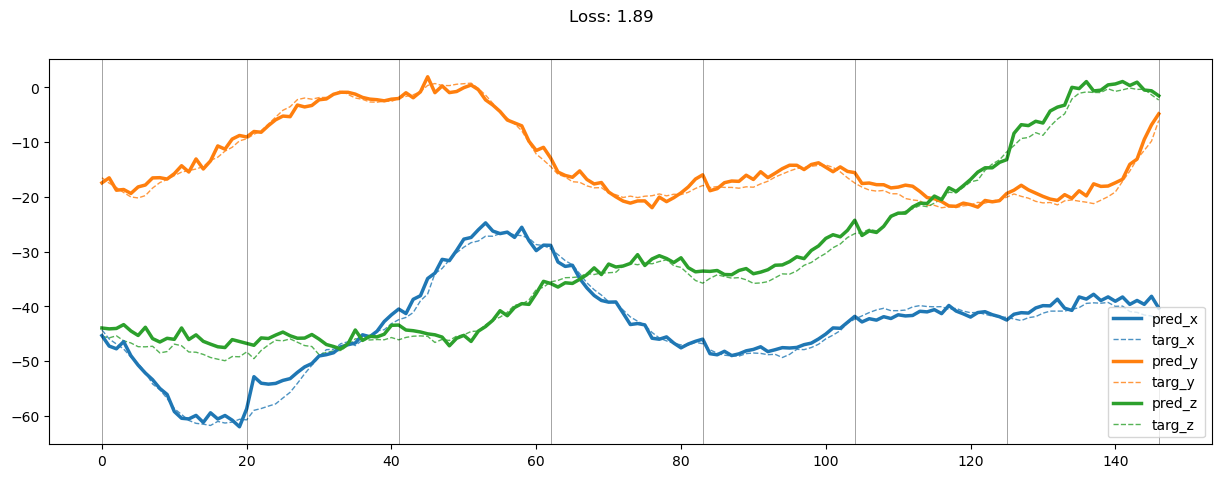

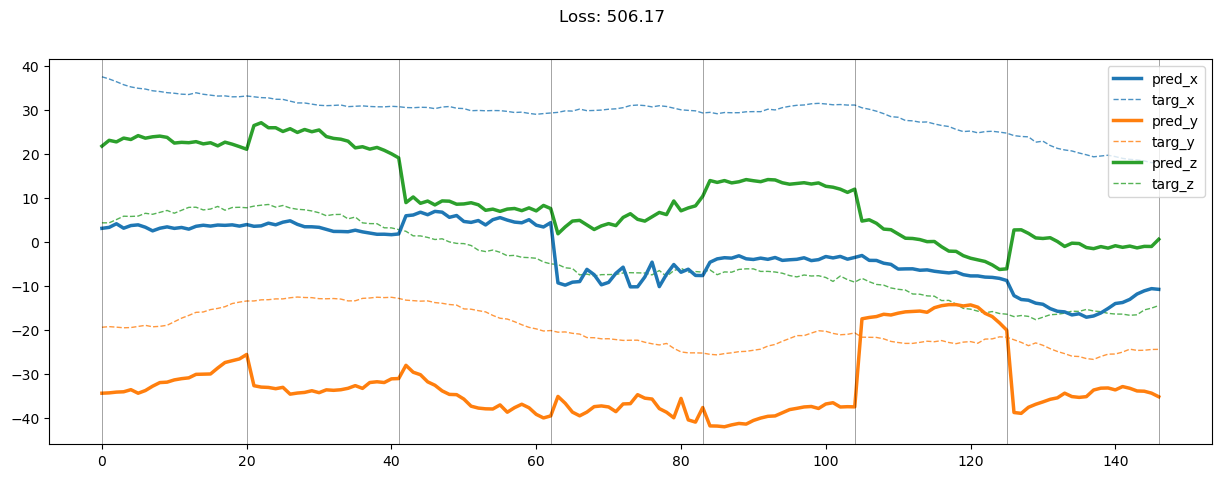

05400: train loss:  2.492, lin acc loss:  0.724, gro loss:  0.135, mag loss:  1.632
       valid loss:  235.805, lin acc loss:  1.391, gro loss:  0.149, mag loss:  234.265
05420: train loss:  2.504, lin acc loss:  0.684, gro loss:  0.128, mag loss:  1.693
       valid loss:  232.665, lin acc loss:  1.395, gro loss:  0.149, mag loss:  231.121
05440: train loss:  2.619, lin acc loss:  0.677, gro loss:  0.136, mag loss:  1.806
       valid loss:  234.478, lin acc loss:  1.403, gro loss:  0.149, mag loss:  232.926
05460: train loss:  2.490, lin acc loss:  0.672, gro loss:  0.129, mag loss:  1.689
       valid loss:  228.784, lin acc loss:  1.417, gro loss:  0.149, mag loss:  227.218
05480: train loss:  2.499, lin acc loss:  0.699, gro loss:  0.138, mag loss:  1.662
       valid loss:  233.123, lin acc loss:  1.400, gro loss:  0.150, mag loss:  231.573
05500: train loss:  2.438, lin acc loss:  0.676, gro loss:  0.133, mag loss:  1.628
       valid loss:  227.858, lin acc loss:  1.388, gro l

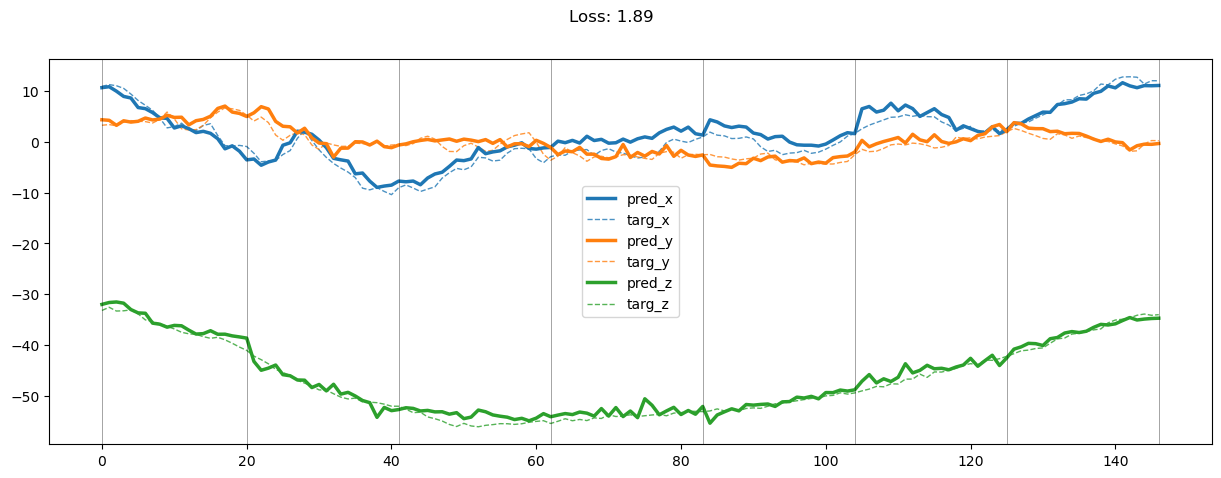

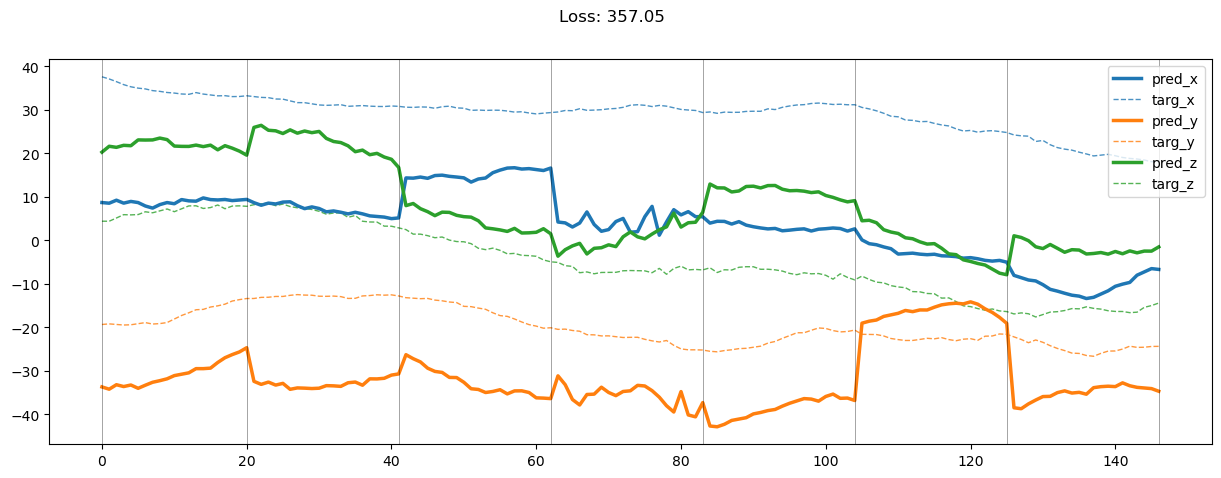

05600: train loss:  2.460, lin acc loss:  0.628, gro loss:  0.131, mag loss:  1.702
       valid loss:  226.230, lin acc loss:  1.435, gro loss:  0.150, mag loss:  224.645
05620: train loss:  2.324, lin acc loss:  0.606, gro loss:  0.126, mag loss:  1.591
       valid loss:  237.088, lin acc loss:  1.448, gro loss:  0.151, mag loss:  235.489
05640: train loss:  2.340, lin acc loss:  0.599, gro loss:  0.119, mag loss:  1.623
       valid loss:  233.405, lin acc loss:  1.446, gro loss:  0.151, mag loss:  231.808
05660: train loss:  2.258, lin acc loss:  0.588, gro loss:  0.127, mag loss:  1.543
       valid loss:  244.746, lin acc loss:  1.441, gro loss:  0.150, mag loss:  243.154
05680: train loss:  2.163, lin acc loss:  0.575, gro loss:  0.119, mag loss:  1.469
       valid loss:  221.894, lin acc loss:  1.460, gro loss:  0.151, mag loss:  220.284
05700: train loss:  2.308, lin acc loss:  0.632, gro loss:  0.136, mag loss:  1.539
       valid loss:  225.937, lin acc loss:  1.453, gro l

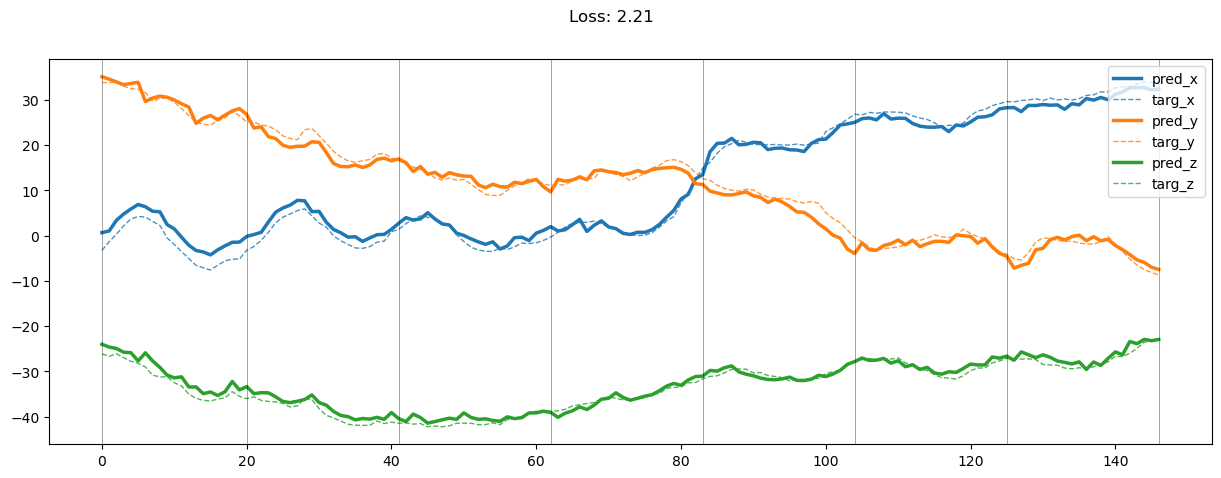

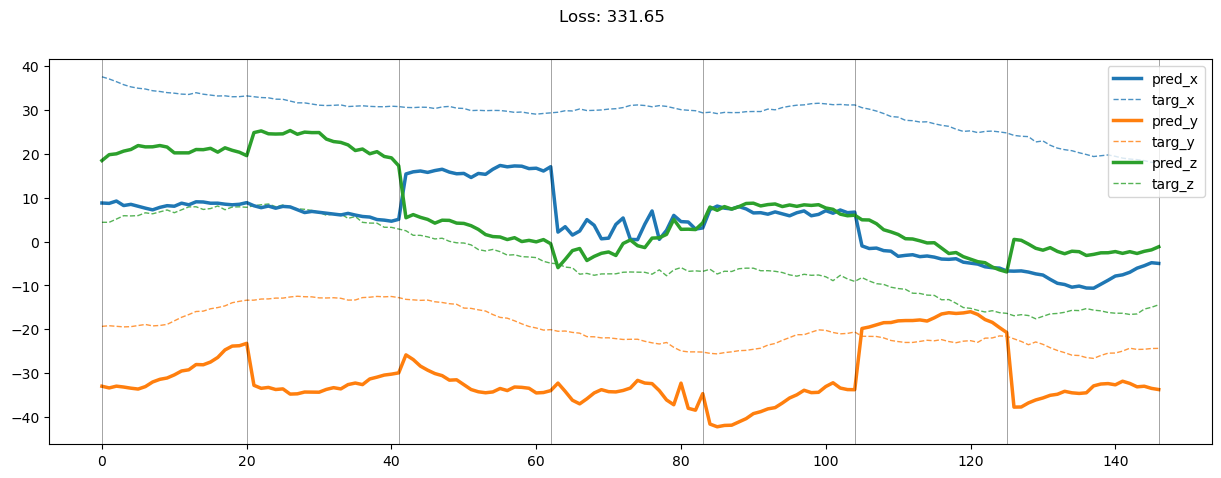

05800: train loss:  2.399, lin acc loss:  0.617, gro loss:  0.133, mag loss:  1.650
       valid loss:  221.343, lin acc loss:  1.470, gro loss:  0.151, mag loss:  219.722
05820: train loss:  2.156, lin acc loss:  0.556, gro loss:  0.119, mag loss:  1.481
       valid loss:  225.653, lin acc loss:  1.474, gro loss:  0.151, mag loss:  224.028
05840: train loss:  2.150, lin acc loss:  0.554, gro loss:  0.124, mag loss:  1.471
       valid loss:  228.227, lin acc loss:  1.490, gro loss:  0.151, mag loss:  226.585
05860: train loss:  2.161, lin acc loss:  0.585, gro loss:  0.125, mag loss:  1.451
       valid loss:  229.996, lin acc loss:  1.484, gro loss:  0.152, mag loss:  228.360
05880: train loss:  2.112, lin acc loss:  0.543, gro loss:  0.119, mag loss:  1.451
       valid loss:  229.108, lin acc loss:  1.514, gro loss:  0.152, mag loss:  227.443
05900: train loss:  2.238, lin acc loss:  0.566, gro loss:  0.131, mag loss:  1.540
       valid loss:  230.216, lin acc loss:  1.511, gro l

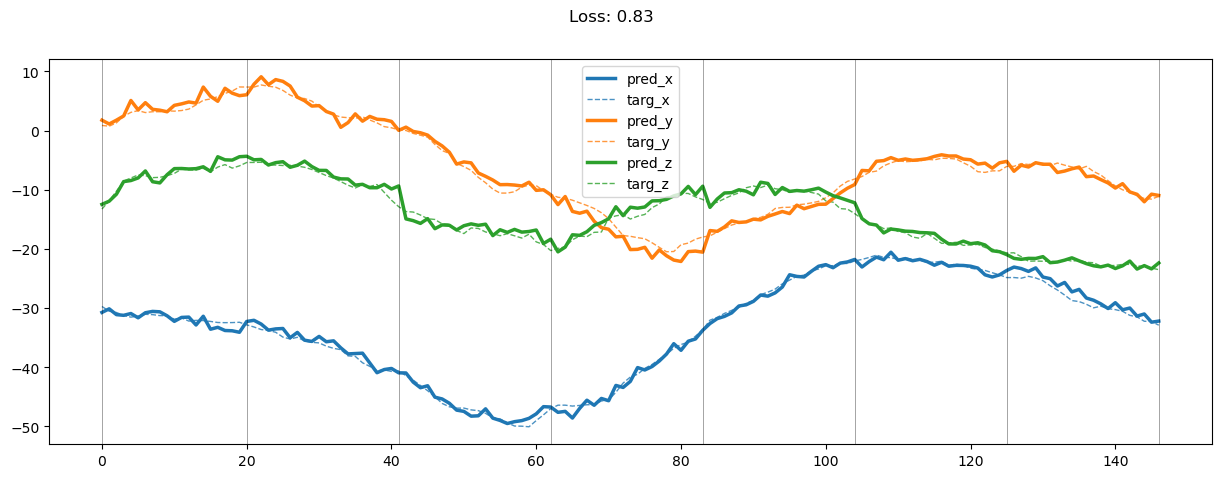

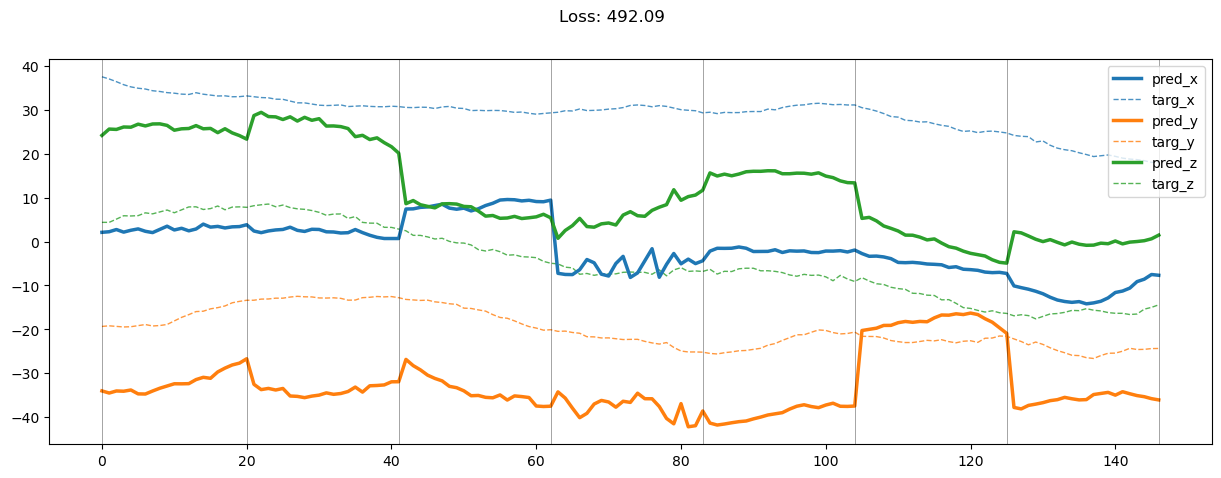

06000: train loss:  2.054, lin acc loss:  0.545, gro loss:  0.122, mag loss:  1.388
       valid loss:  234.851, lin acc loss:  1.508, gro loss:  0.152, mag loss:  233.192


In [29]:
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_lin_acc_loss, train_gro_loss, train_mag_loss = train(train_loader, draw)
    valid_loss, valid_lin_acc_loss, valid_gro_loss, valid_mag_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch+1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, lin acc loss: {train_lin_acc_loss: 2.3f}, gro loss: {train_gro_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, lin acc loss: {valid_lin_acc_loss: 2.3f}, gro loss: {valid_gro_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}')

In [30]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            results.extend(zip(predict_data[:, :, :, 6:9].detach().cpu().numpy(), target_data[:, :, :, 6:9].cpu().numpy()))
    
    return np.array(results)

In [31]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(296, 2, 7, 21, 3)


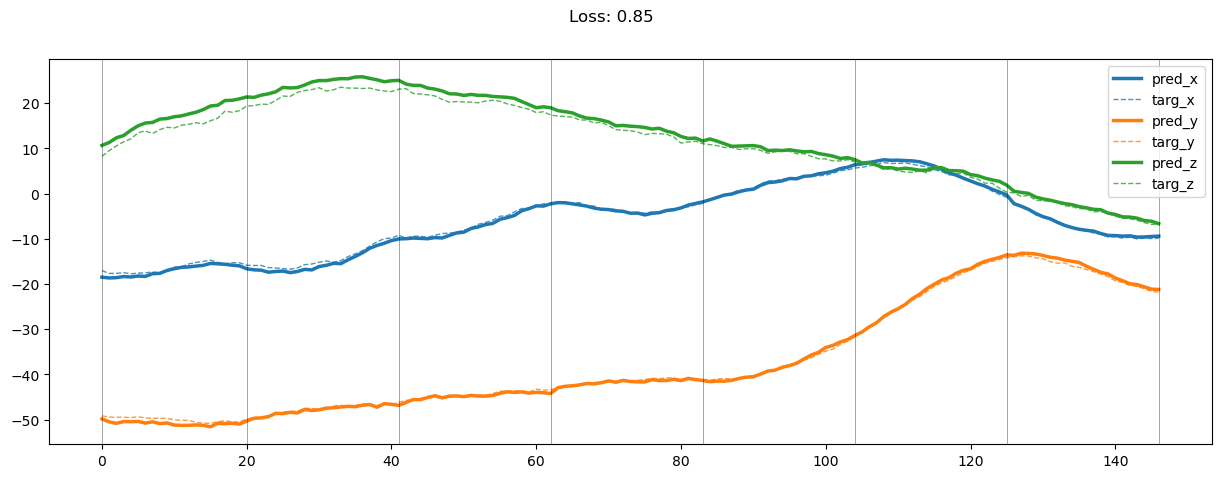

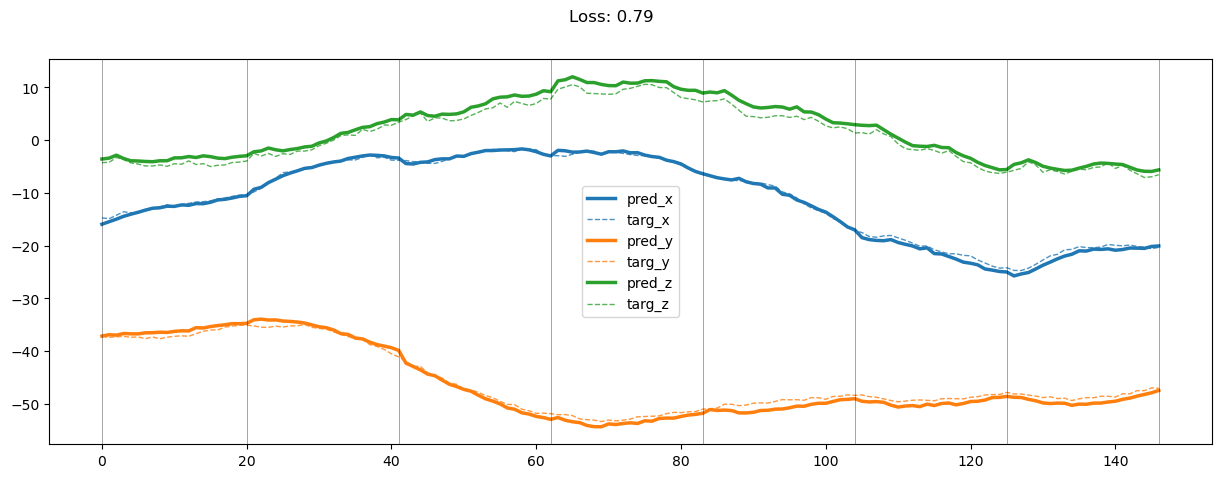

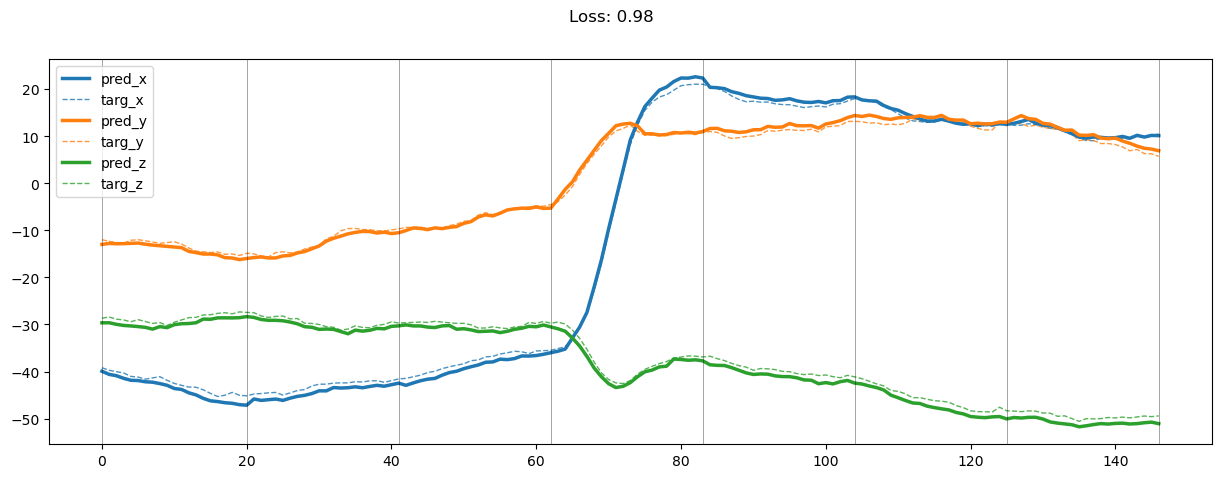

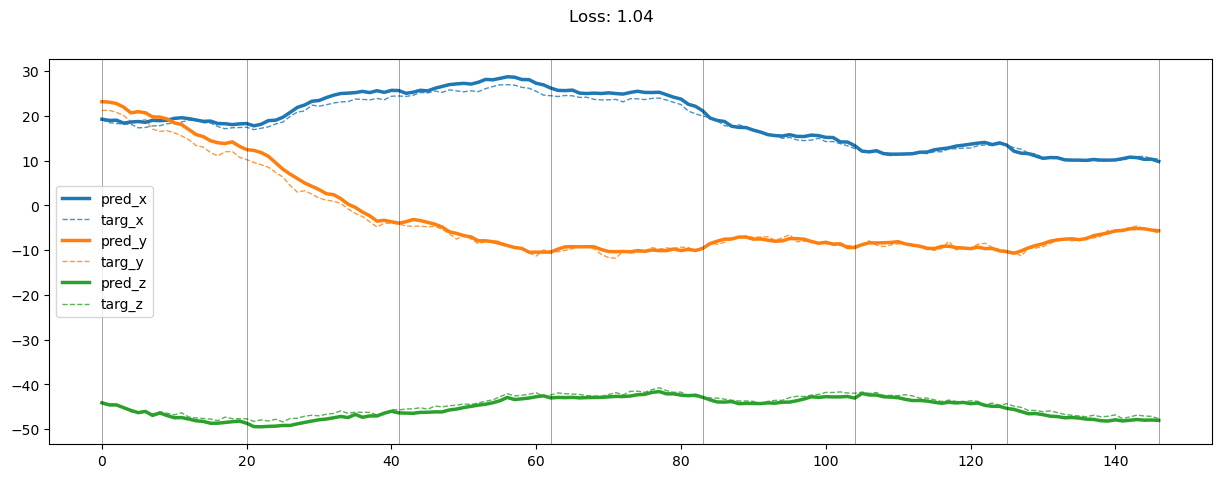

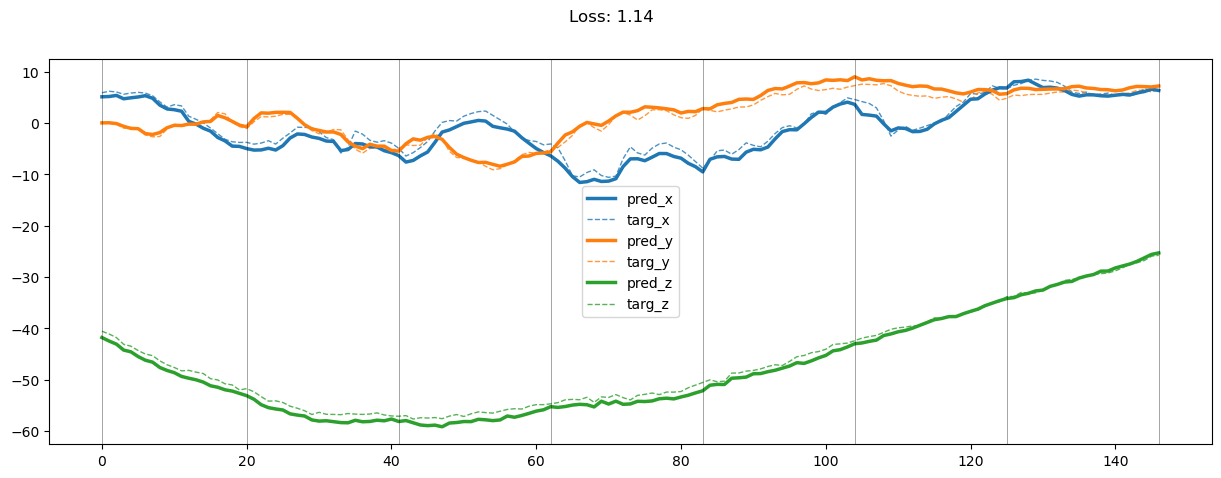

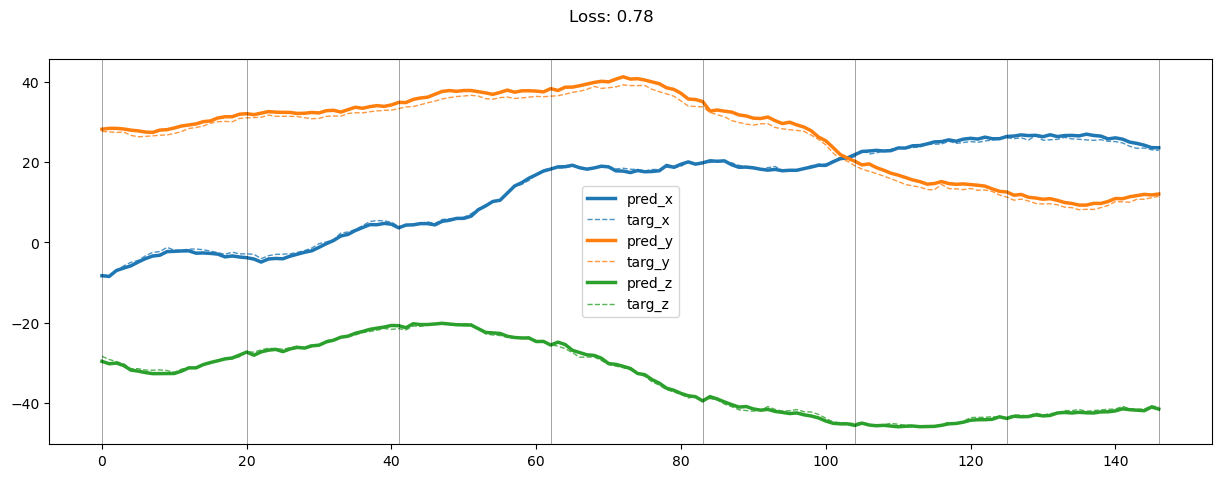

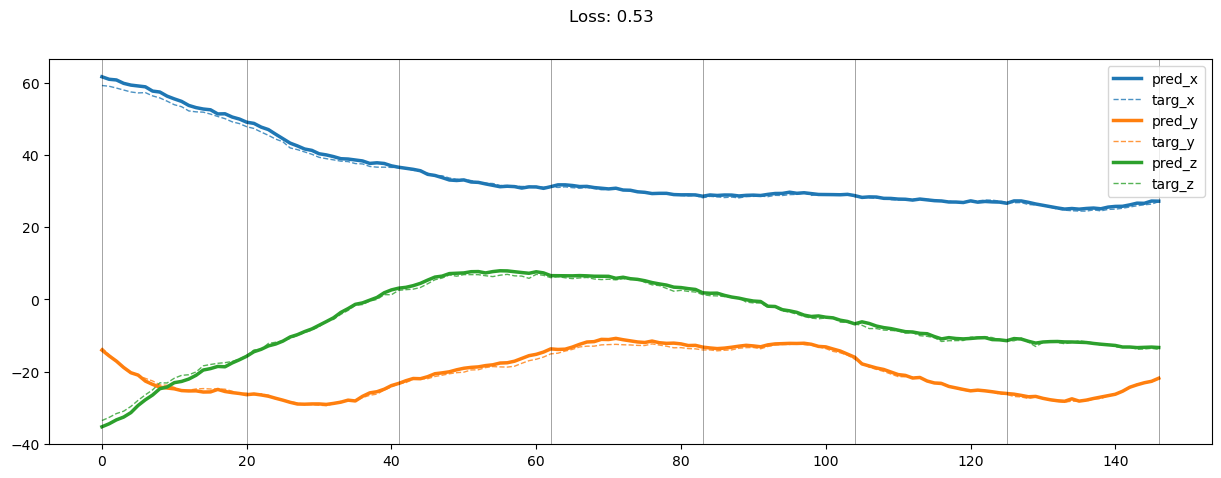

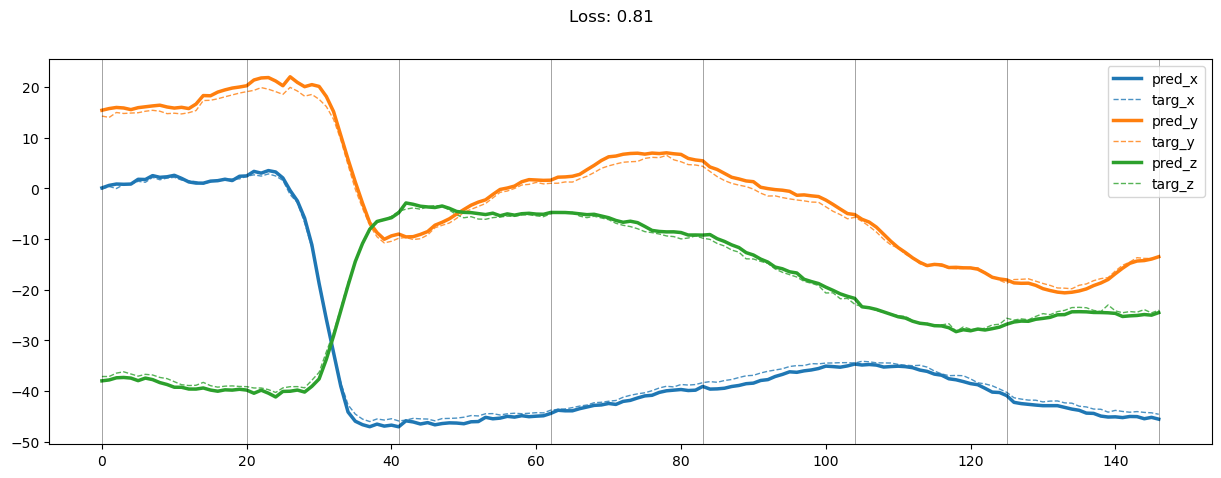

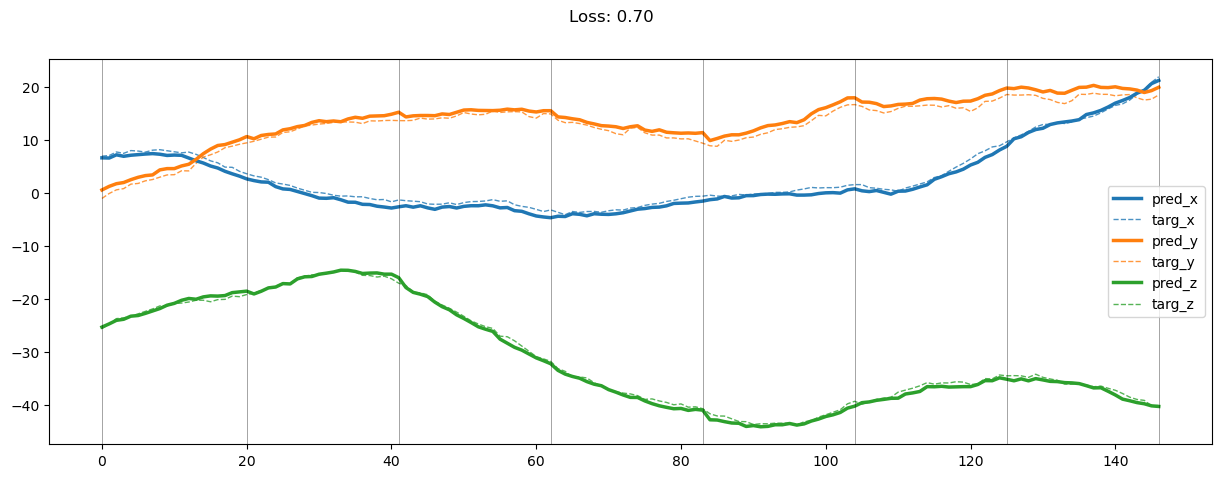

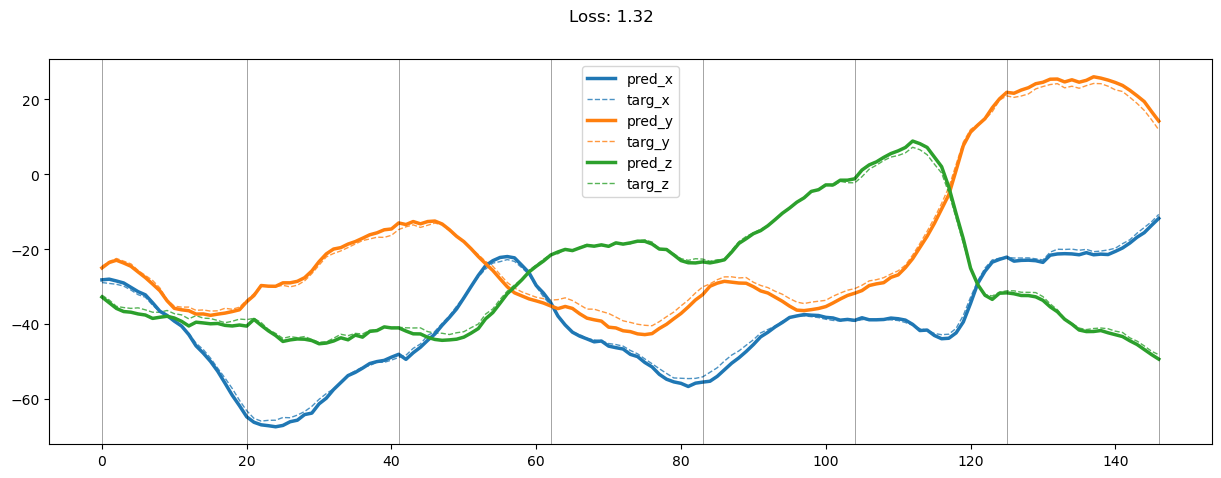

In [32]:
results = output_eval(model, train_loader)

print(results.shape)

for rs in results[::30]:
    plot_result(rs)

(74, 2, 7, 21, 3)


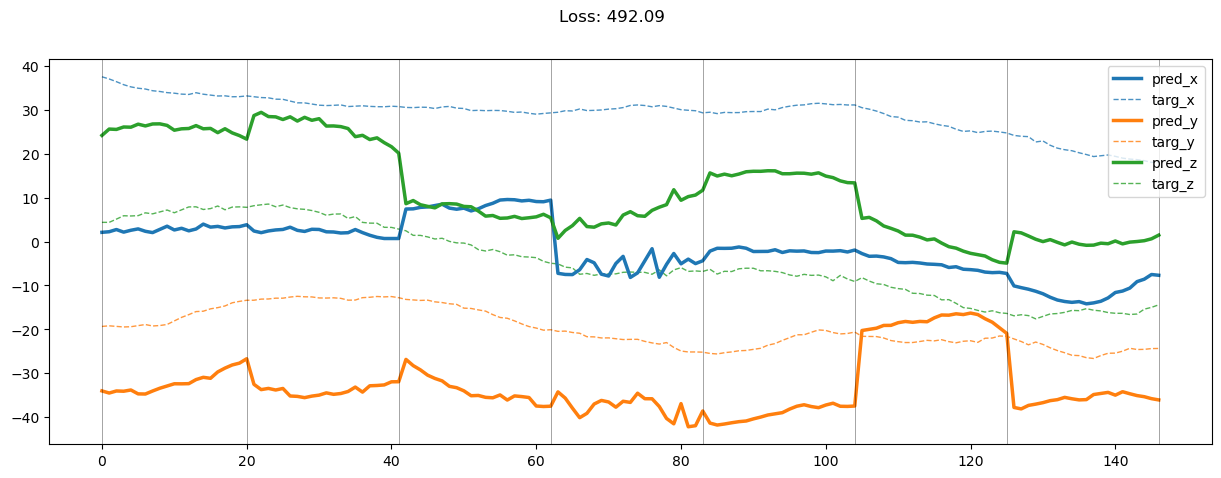

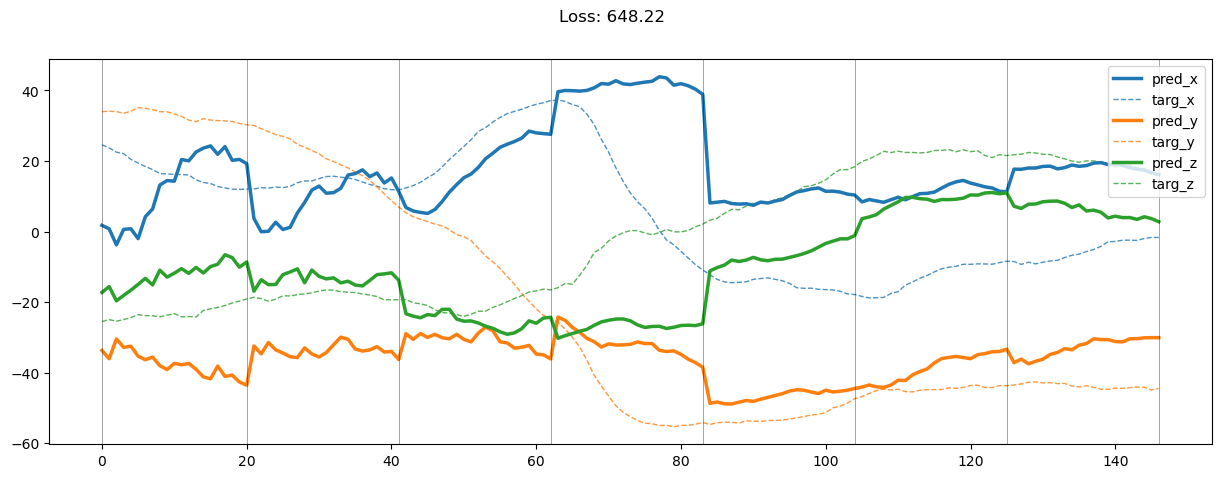

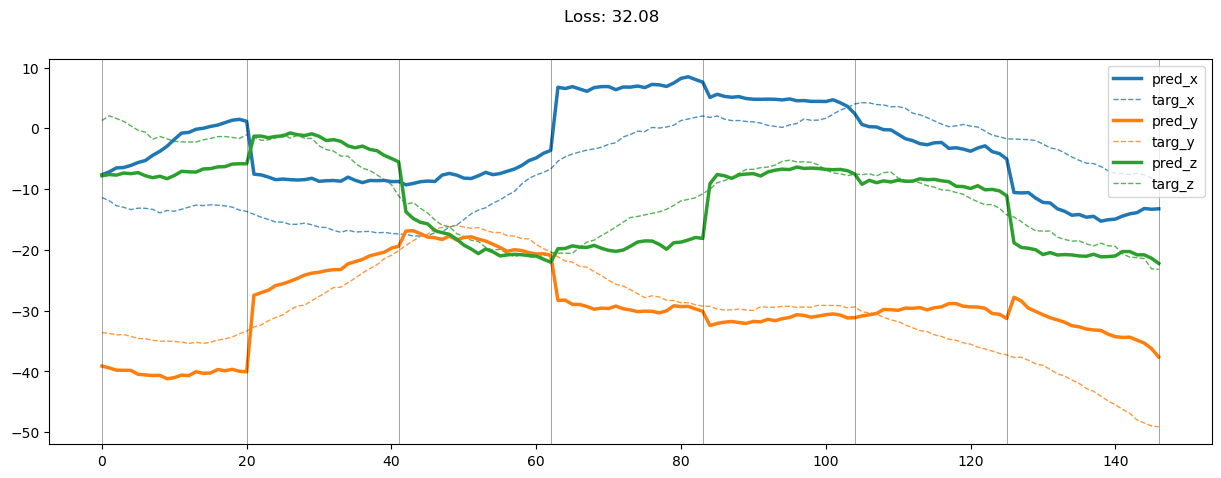

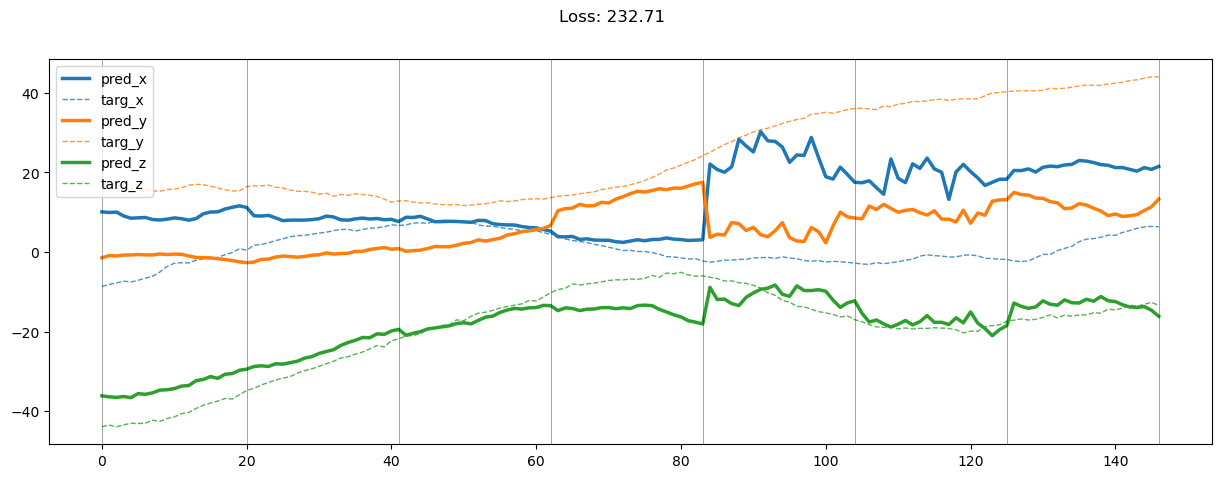

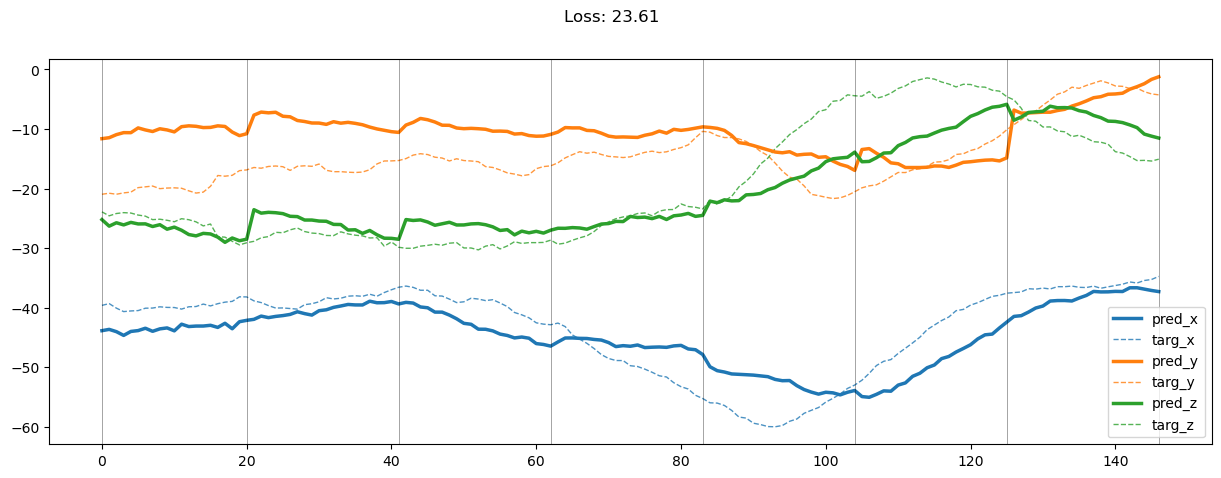

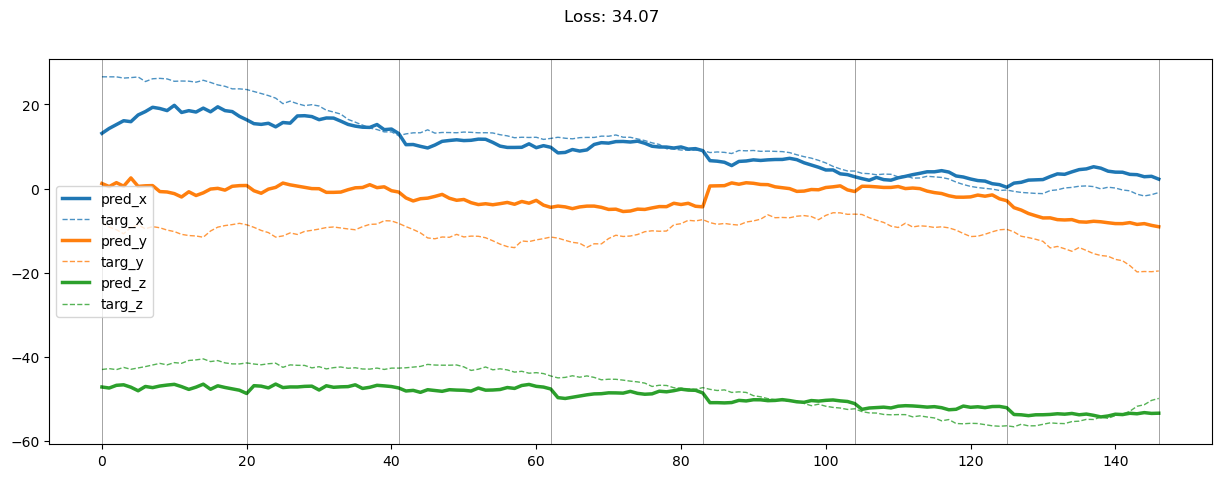

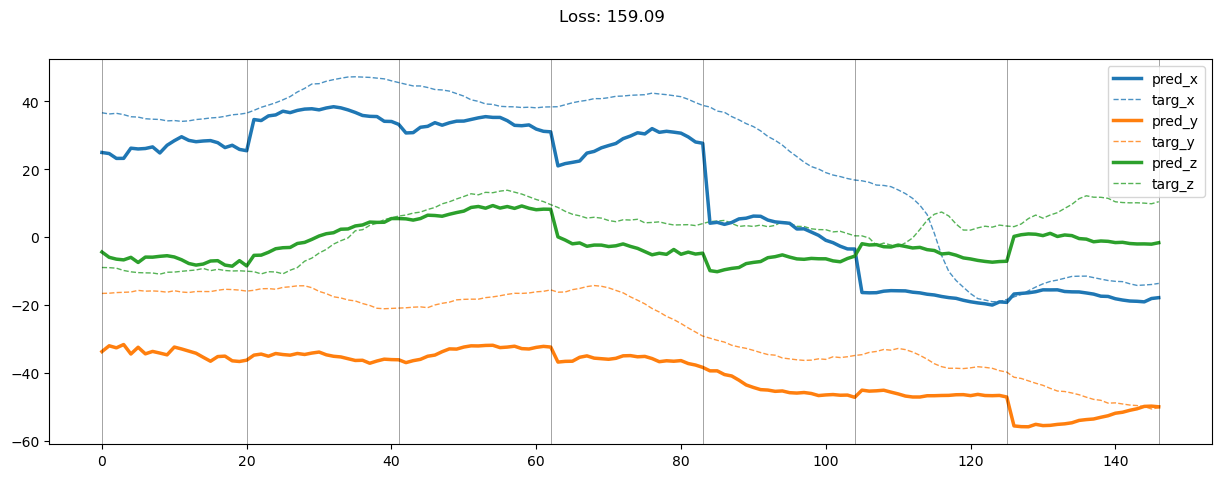

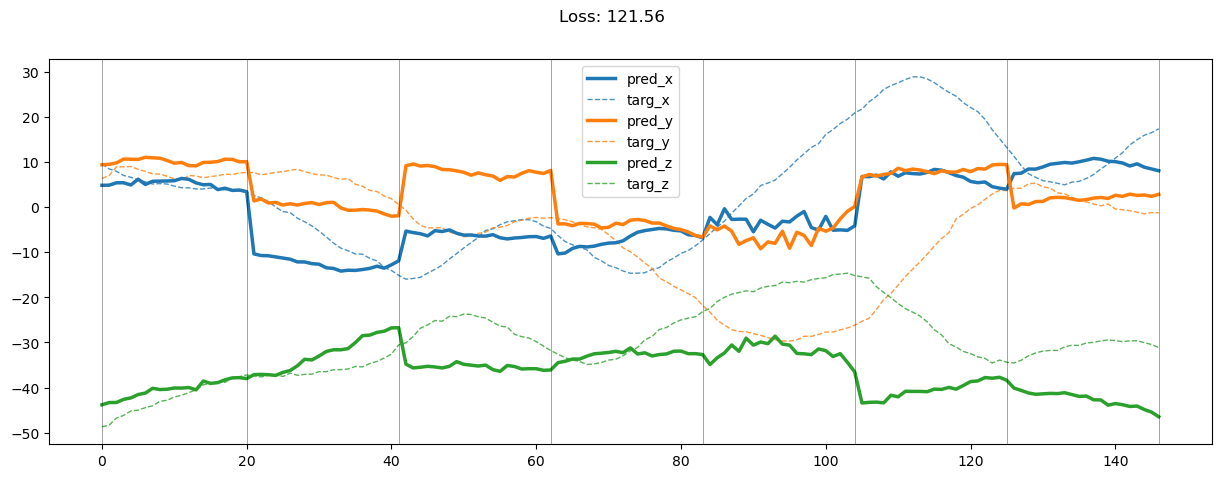

In [33]:
results = output_eval(model, valid_loader)

print(results.shape)

for rs in results[::10]:
    plot_result(rs)